In [14]:
from numpy.lib import scimath
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from clouddrift.wavelet import (
    morse_wavelet_transform,
    morse_logspace_freq,
)
from clouddrift.sphere import coriolis_frequency
from clouddrift.ridges import (
    instmom_univariate,
    instmom_multivariate,
    isridgepoint,
    separate_ridge_groups_dbscan,
    ridge_shift_interpolation,
    get_group_data,
    separate_ridge_groups_frequency
)
import clouddrift as cd
from clouddrift.datasets import gdp1h
from typing import Optional, Union, Tuple, List
from numpy.typing import NDArray
import matplotlib.cm as cm
from tqdm import tqdm
from sklearn.cluster import DBSCAN
import time
import pandas as pd
from scipy import integrate


def synth_signal(t, tau, omega, k):
    '''
    Generates a synthetic signal based on the given parameters.
    The signal is defined in the complex plane and is then separated into
    its real and imaginary components.
    '''

    # Makes a piecewise function where for t < tau/4, the signal is -1 
    # and for t >= tau/4, the signal is defined with complex-safe sqrt
    xi_t = np.piecewise(
        t,
        [t < tau/4.0, t >= tau/4.0],
        [
            -1.0,
            lambda x: -scimath.sqrt(1.0 - (1/3.0*(4.0 * x / tau - 1.0)) ** 2.0),
        ],
    )

    k_t = k * (1 + 5.0 * t / tau)

    a_t = k_t * scimath.sqrt(1.0 + scimath.sqrt(1.0 - xi_t**2.0))
    b_t = k_t * scimath.sqrt(1.0 - scimath.sqrt(1.0 - xi_t**2.0))

    phi_t = omega * t * (1.0 + t / tau)
    theta_t = np.pi / 2.0 - omega * t / 10.0

    z_t = np.exp(1j * theta_t) * (a_t * np.cos(phi_t) - 1j * b_t * np.sin(phi_t))

    x_t = z_t.real
    y_t = z_t.imag
    return x_t, y_t

def add_drift(x_t, y_t, t):
    '''
    Adds a westward drift and a stochastic component to the y_t component.

    Parameters
    ----------
    x_t : np.ndarray
        The x_t component of the synthetic signal.
    y_t : np.ndarray
        The y_t component of the synthetic signal.
    t : np.ndarray
        The time vector in days.

    Returns
    -------
    x_t_drifted : np.ndarray
        The drifted x_t component.
    y_t_drifted : np.ndarray
        The drifted y_t component.
    westward_drift : np.ndarray
        The westward drift component.
    stochastic_displacement : np.ndarray
        The stochastic displacement component.
    '''

    # 1. Uniform Westward Drift
    westward_drift_speed = -0.5 / 100 / 1000  # cm/s to km/s, westward is negative in y direction
    westward_drift = westward_drift_speed * t * 24 * 3600  # km/s * seconds in a day = meters

    # 2. Add all components to x_t and y_t
    x_t_drifted = x_t + westward_drift
    y_t_drifted = y_t

    return x_t_drifted, y_t_drifted, westward_drift


In [15]:
def extract_constant_frequency_segments(
    ridge_coords: List[Tuple[int, int]],
    freq_tolerance: float = 0.0,
    min_segment_length: int = 2
) -> List[Tuple[int, int]]:
    '''
    Find segments of constant frequency within a cluster and extract central points.
    
    For each segment where the frequency remains constant, identify the point
    closest to the central time of that segment.
    
    Parameters
    ----------
    ridge_coords : List[Tuple[int, int]]
        List of (frequency, time) points in a single cluster
    freq_tolerance : float, optional
        Maximum allowed frequency variation to be considered "constant" (default: 0.0)
    min_segment_length : int, optional
        Minimum number of points required for a segment (default: 2)
        
    Returns
    -------
    central_points : List[Tuple[int, int]]
        List of (frequency, time) points representing the central point of each segment
    '''
    if not ridge_coords:
        return []
    
    # Sort points by time
    sorted_coords = sorted(ridge_coords, key=lambda pt: pt[1])
    
    central_points = []
    segment_start = 0
    ref_freq = sorted_coords[0][0]
    
    # Process points to find segments with constant frequency
    for i in range(1, len(sorted_coords)):
        freq, time = sorted_coords[i]
        
        # Check if frequency changed beyond tolerance
        if abs(freq - ref_freq) > freq_tolerance:
            # End of segment
            segment_length = i - segment_start
            
            if segment_length >= min_segment_length:
                # Extract segment
                segment = sorted_coords[segment_start:i]
                
                # Get times for this segment
                segment_times = [pt[1] for pt in segment]
                
                # Calculate central time
                central_time = sum(segment_times) / len(segment_times)
                
                # Find point closest to central time
                closest_idx = min(range(len(segment)), key=lambda j: abs(segment[j][1] - central_time))
                central_points.append(segment[closest_idx])
            else:
                # For short segments, add all points
                central_points.extend(sorted_coords[segment_start:i])
            
            # Start new segment
            segment_start = i
            ref_freq = freq
    
    # Process final segment
    segment_length = len(sorted_coords) - segment_start
    if segment_length >= min_segment_length:
        segment = sorted_coords[segment_start:]
        segment_times = [pt[1] for pt in segment]
        central_time = sum(segment_times) / len(segment_times)
        closest_idx = min(range(len(segment)), key=lambda j: abs(segment[j][1] - central_time))
        central_points.append(segment[closest_idx])
    else:
        # For short segments, add all points
        central_points.extend(sorted_coords[segment_start:])
    
    return central_points

In [16]:
# Create a time array for 1000 days
t = np.linspace(0, 1000, 1000)

# Generate a synthetic signal with a chirp component
tau = 1000.0
omega = 0.05
k = 10.0

x_t, y_t = synth_signal(t, tau, omega, k)

# Add drift to the synthetic signal
x_t_drifted, y_t_drifted, westward_drift = add_drift(x_t, y_t, t)

# Copy in the matern noise from the following path with columns (t, noise_real, noise_imaginary):
path = "/vol/clouddrift/matern_displacement.txt"

# Load the matern noise data
matern_data = np.loadtxt(path, delimiter=",", skiprows=1)

# Extract the time and noise components
matern_t = matern_data[:, 0]
matern_noise_real = matern_data[:, 1]
matern_noise_imaginary = matern_data[:, 2]


# Add real component of matern noise to x_t_drifted
x_t_drifted_wNoise = x_t_drifted + matern_noise_real

# Add imaginary component of matern noise to y_t_drifted
y_t_drifted_wNoise = y_t_drifted + matern_noise_imaginary

In [17]:
# Initialize storage for results
all_timing_results = []
all_interpolation_times = []

# Run the entire analysis 100 times
num_runs = 100
print(f"Running full analysis {num_runs} times...")

for run in tqdm(range(num_runs)):
    # Create a dictionary to store timing results for this run
    timing_results = {}
    
    # Overall timing
    start_time_total = time.time()
    
    # Morse wavelet parameters
    gamma = 3
    beta = 2
    
    # Time the frequency generation
    t1 = time.time()
    freqs = morse_logspace_freq(gamma, beta, len(t), density=4)
    timing_results['Generate frequencies'] = time.time() - t1
    
    # Time the wavelet transforms
    t1 = time.time()
    wavelet_x = morse_wavelet_transform(x_t_drifted_wNoise, gamma, beta, freqs, boundary="mirror")
    wavelet_y = morse_wavelet_transform(y_t_drifted_wNoise, gamma, beta, freqs, boundary="mirror")
    timing_results['Wavelet transforms'] = time.time() - t1
    
    # Time the power calculation
    t1 = time.time()
    power = np.abs(wavelet_x)**2 + np.abs(wavelet_y)**2
    periods = 2 * np.pi / freqs
    timing_results['Calculate power'] = time.time() - t1
    
    # Time the ridge point detection
    t1 = time.time()
    ridge_points, ridge_quantity, processed_transform, inst_frequency = isridgepoint(
        wavelet_transform=power,
        scale_frequencies=freqs,
        amplitude_threshold=0.1,
        ridge_type='amplitude'
    )
    timing_results['Ridge point detection'] = time.time() - t1
    
    # Time the ridge group separation
    t1 = time.time()
    labeled_ridges, num_groups = separate_ridge_groups_dbscan(
        ridge_points, 
        eps=5.0,
        min_samples=3,
        scale_factor=1.5
    )
    timing_results['Separate ridge groups'] = time.time() - t1
    
    # Time the interpolation of all groups
    t1 = time.time()
    interpolation_times = []
    
    for group_id in range(1, num_groups + 1):
        group_start = time.time()
        
        # Extract ridge mask for the group
        group_mask = (labeled_ridges == group_id)
        
        # Create frequency meshgrid
        freq_mesh = np.zeros_like(power)
        for i, f in enumerate(freqs):
            freq_mesh[i, :] = f
        
        # Apply ridge interpolation
        interpolated_arrays = ridge_shift_interpolation(
            ridge_points=group_mask,
            ridge_quantity=power,
            y_arrays=[power, freq_mesh]
        )
        
        # Get the group size
        group_size = np.sum(group_mask)
        
        # Record the time for this group
        group_time = time.time() - group_start
        interpolation_times.append((group_id, group_size, group_time, run))
    
    timing_results['Total interpolation'] = time.time() - t1
    
    # Calculate total runtime
    total_runtime = time.time() - start_time_total
    timing_results['Total runtime'] = total_runtime
    
    # Add run number to timing results
    timing_results['Run'] = run
    
    # Store results for this run
    all_timing_results.append(timing_results)
    all_interpolation_times.extend(interpolation_times)

# Convert to DataFrames for analysis
timing_df = pd.DataFrame(all_timing_results)
interp_df = pd.DataFrame(all_interpolation_times, 
                         columns=['Group ID', 'Points', 'Time (s)', 'Run'])

# Calculate statistics for each step
stats_df = timing_df.describe().T
stats_df = stats_df.sort_values('mean', ascending=False)

# Display timing statistics
print("\n===== Timing Statistics (seconds) =====")
print(stats_df[['mean', 'std', 'min', '50%', 'max']])

# Calculate percentage of total runtime
mean_total = stats_df.loc['Total runtime', 'mean']
percent_df = pd.DataFrame({
    'Step': stats_df.index,
    'Mean Time (s)': stats_df['mean'],
    '% of Total': stats_df['mean'] / mean_total * 100
})
percent_df = percent_df[percent_df['Step'] != 'Total runtime']
percent_df = percent_df[percent_df['Step'] != 'Run']
percent_df = percent_df.sort_values('% of Total', ascending=False)

print("\n===== Percentage of Total Runtime =====")
print(percent_df)

# Calculate statistics for the interpolation by group size
interp_stats = interp_df.groupby('Points')['Time (s)'].agg(['mean', 'std', 'min', 'median', 'max', 'count'])
interp_stats['points_per_second'] = interp_stats['count'] / interp_stats['mean']
interp_stats = interp_stats.reset_index()

print("\n===== Interpolation Time by Group Size =====")
print(interp_stats.sort_values('mean', ascending=False).head(10))

Running full analysis 100 times...


100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


===== Timing Statistics (seconds) =====
                            mean        std       min        50%        max
Run                    49.500000  29.011492  0.000000  49.500000  99.000000
Total runtime           0.036339   0.002454  0.033289   0.035816   0.048013
Wavelet transforms      0.026296   0.001907  0.024083   0.025908   0.036893
Separate ridge groups   0.004255   0.000347  0.003885   0.004194   0.006506
Ridge point detection   0.002555   0.000161  0.002354   0.002520   0.003625
Total interpolation     0.002317   0.000127  0.002166   0.002272   0.002685
Generate frequencies    0.000758   0.000407  0.000365   0.000564   0.001834
Calculate power         0.000151   0.000021  0.000123   0.000145   0.000221

===== Percentage of Total Runtime =====
                                        Step  Mean Time (s)  % of Total
Wavelet transforms        Wavelet transforms       0.026296   72.364822
Separate ridge groups  Separate ridge groups       0.004255   11.708106
Ridge point detect

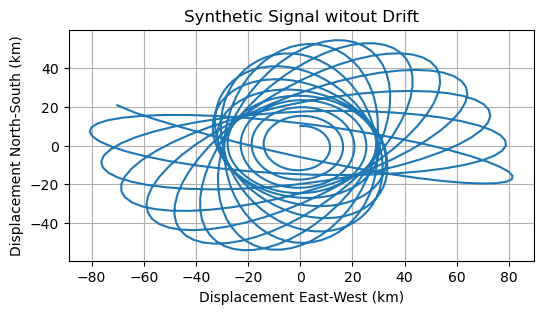

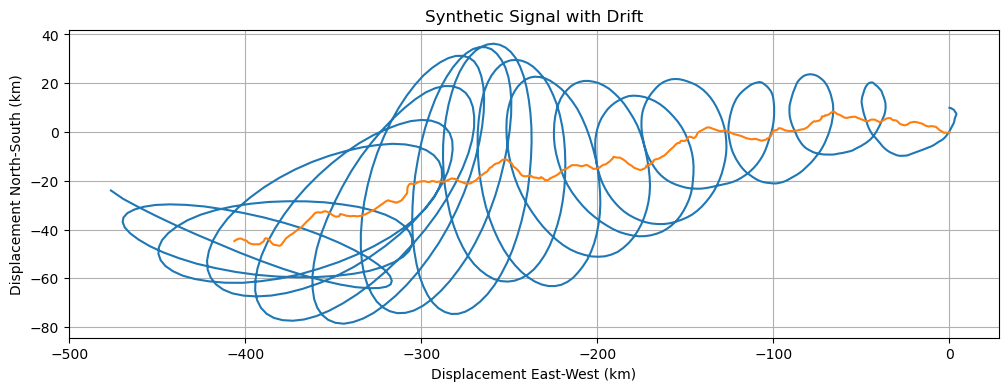

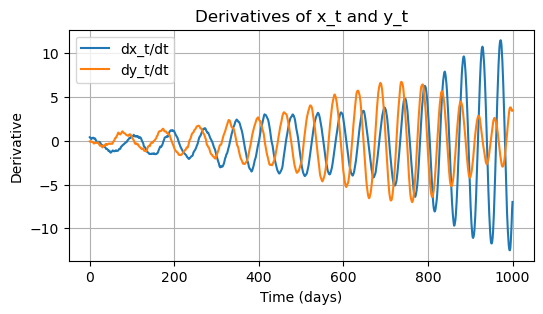

In [18]:
# Create a time array for 1000 days
t = np.linspace(0, 1000, 1000)

# Generate a synthetic signal with a chirp component
tau = 1000.0
omega = 0.05
k = 10.0

x_t, y_t = synth_signal(t, tau, omega, k)

# Add drift to the synthetic signal
x_t_drifted, y_t_drifted, westward_drift = add_drift(x_t, y_t, t)

# Copy in the matern noise from the following path with columns (t, noise_real, noise_imaginary):
path = "/vol/clouddrift/matern_displacement.txt"

# Load the matern noise data
matern_data = np.loadtxt(path, delimiter=",", skiprows=1)

# Extract the time and noise components
matern_t = matern_data[:, 0]
matern_noise_real = matern_data[:, 1]
matern_noise_imaginary = matern_data[:, 2]


# Add real component of matern noise to x_t_drifted
x_t_drifted_wNoise = x_t_drifted + matern_noise_real

# Add imaginary component of matern noise to y_t_drifted
y_t_drifted_wNoise = y_t_drifted + matern_noise_imaginary

# Plot the synthetic signal without drift
plt.figure(figsize=(6, 3))
plt.plot(x_t, y_t, label="Synthetic Signal")
plt.xlabel("Displacement East-West (km)")
plt.ylabel("Displacement North-South (km)")
plt.title("Synthetic Signal witout Drift")
plt.grid(True)
plt.show()

# Plot the synthetic signal with the real component as the x-axis and the imaginary component as the y-axis
plt.figure(figsize=(12, 4))
plt.plot(x_t_drifted_wNoise, y_t_drifted_wNoise, label="Synthetic Signal")
plt.plot(westward_drift + matern_noise_real, matern_noise_imaginary, label="Just Noise & Drift")
plt.xlabel("Displacement East-West (km)")
plt.ylabel("Displacement North-South (km)")
plt.title("Synthetic Signal with Drift")
plt.grid(True)
plt.show()

# Plot the derivatives of x_t and y_t
plt.figure(figsize=(6, 3))
plt.plot(t, np.gradient(x_t_drifted_wNoise, t[1] - t[0]), label="dx_t/dt")
plt.plot(t, np.gradient(y_t_drifted_wNoise, t[1] - t[0]), label="dy_t/dt")
plt.xlabel("Time (days)")
plt.ylabel("Derivative")
plt.title("Derivatives of x_t and y_t")
plt.legend()
plt.grid(True)
plt.show()

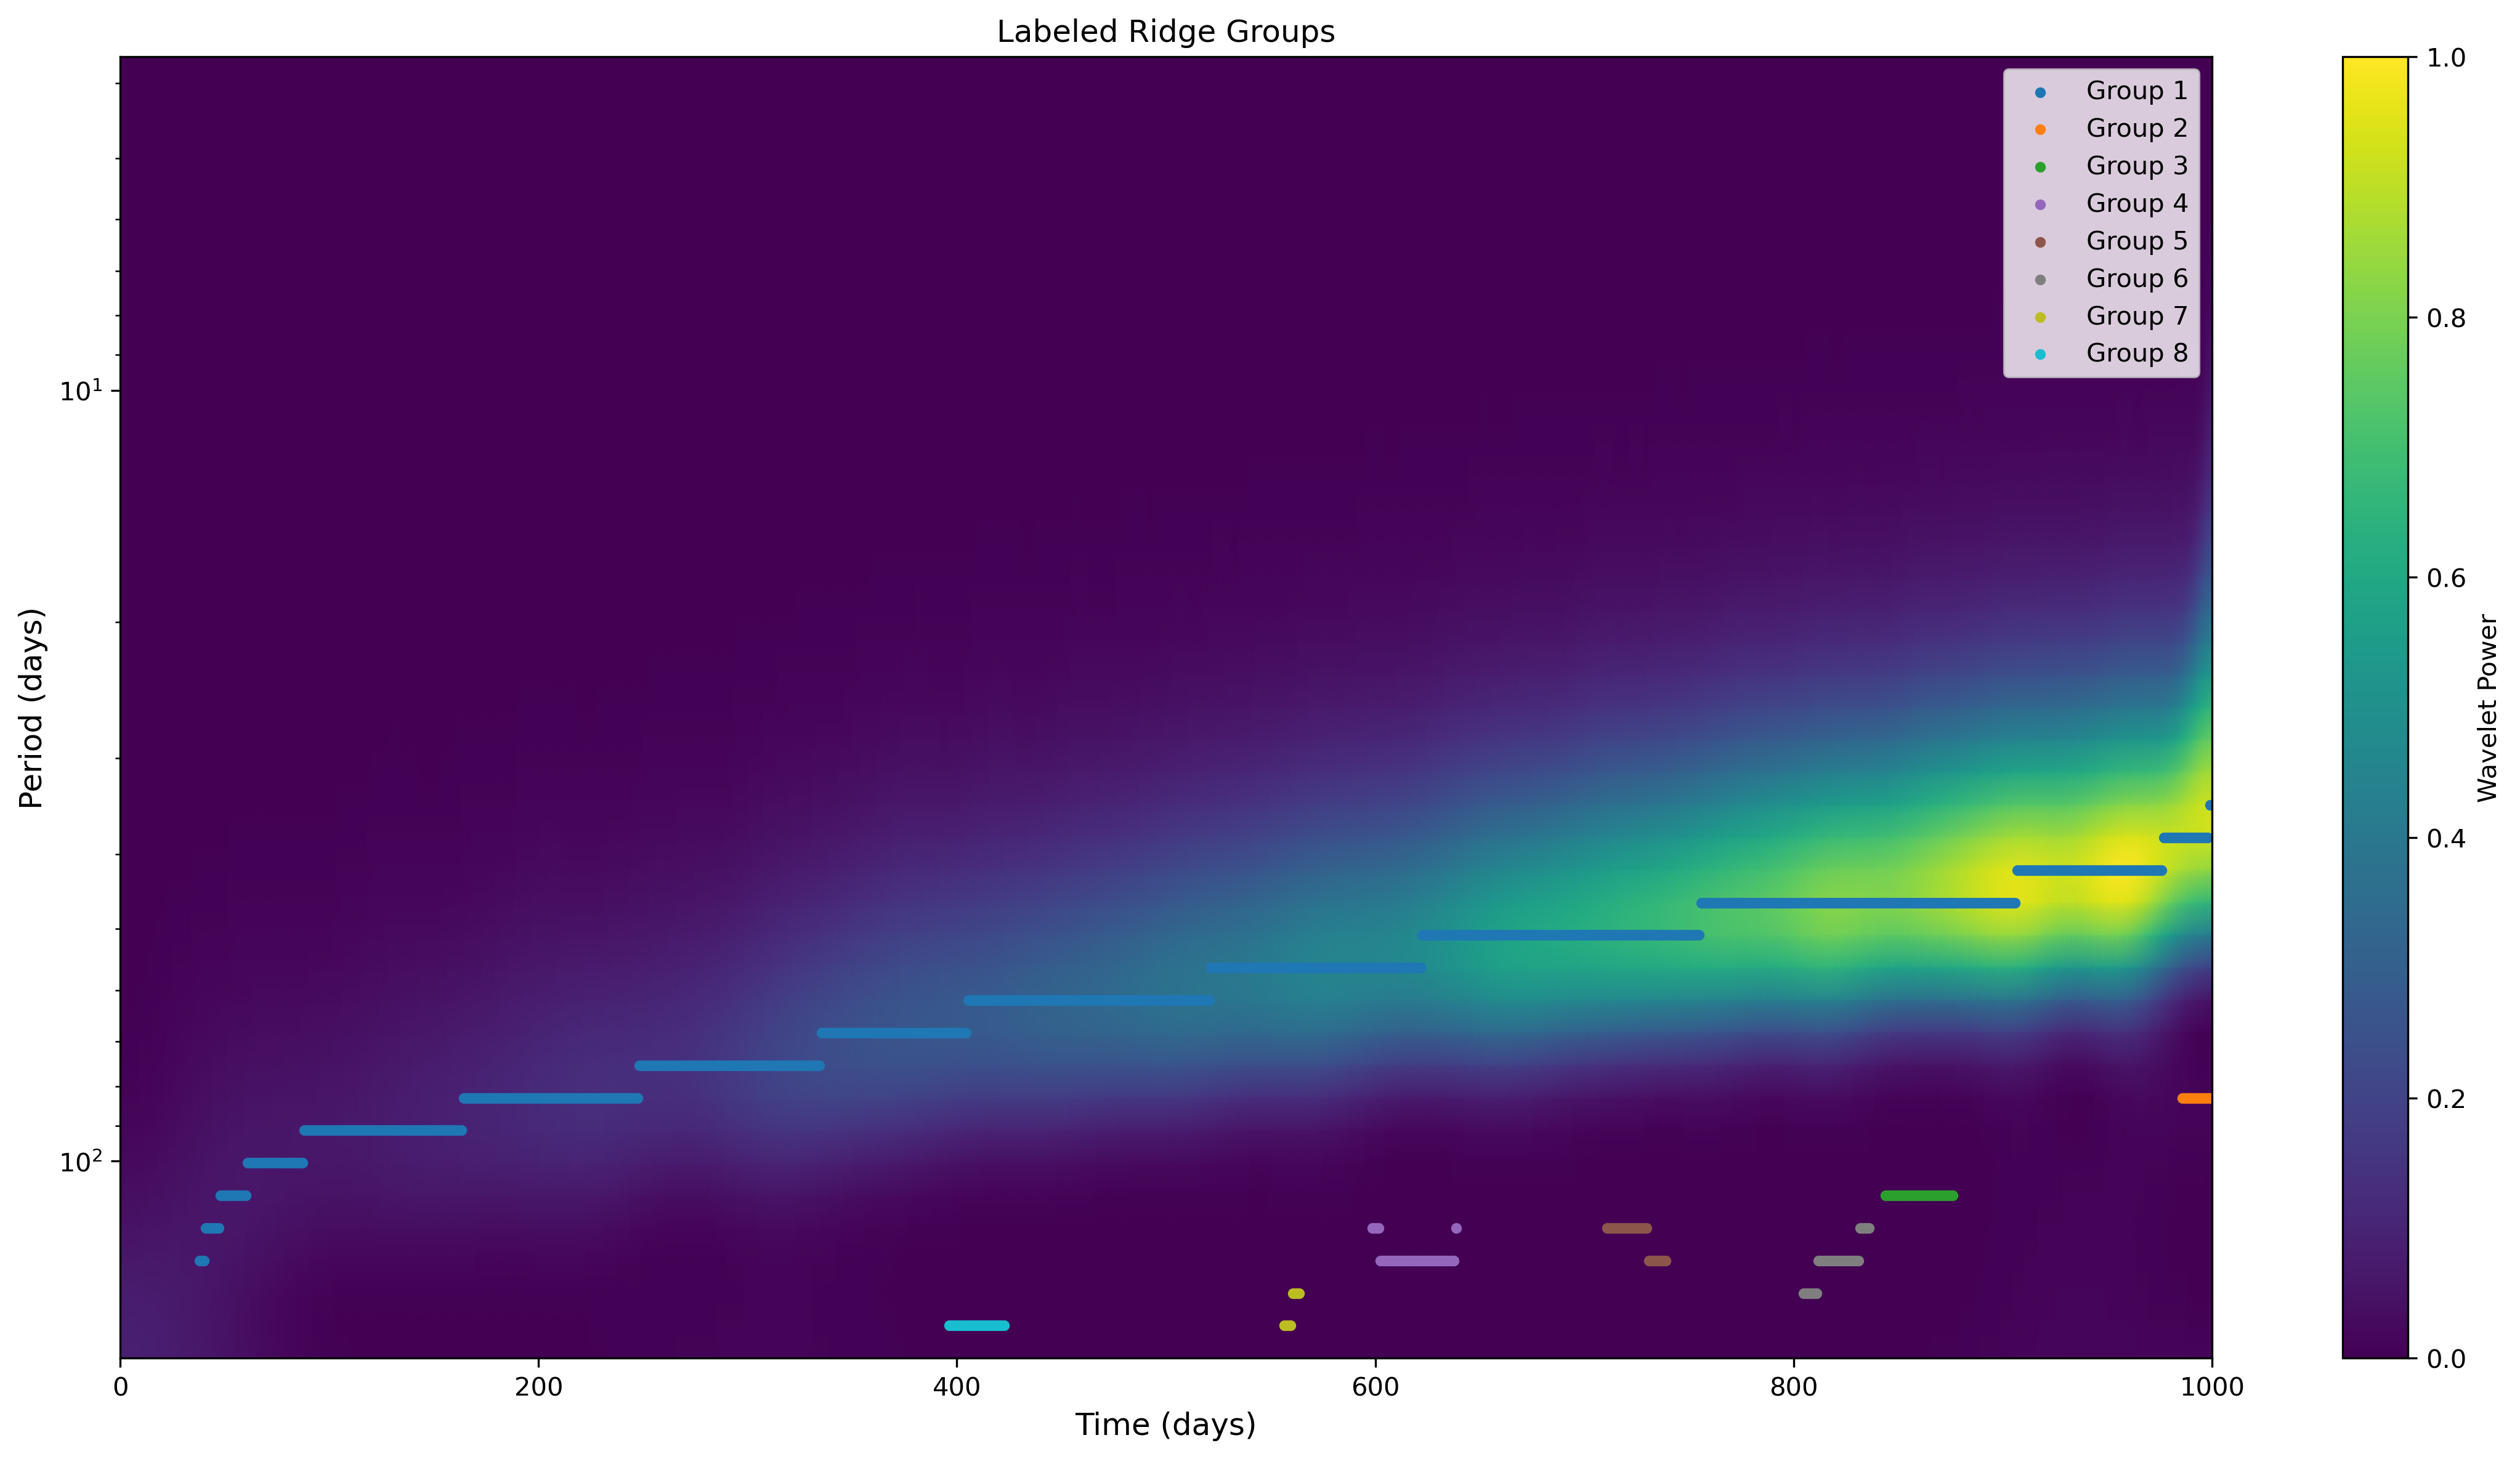

In [19]:
# Define Morse wavelet parameters
gamma = 3  # Controls time-frequency resolution trade-off
beta = 2   # Controls shape/symmetry of the wavelet

# Generate logarithmically spaced frequencies for analysis
freqs = morse_logspace_freq(gamma, beta, len(t), density=4)

# Apply the Morse wavelet transform to the synthetic signal (returns frequency/time, not scale/time)
wavelet_x = morse_wavelet_transform(x_t_drifted_wNoise, gamma, beta, freqs, boundary="mirror")
wavelet_y = morse_wavelet_transform(y_t_drifted_wNoise, gamma, beta, freqs, boundary="mirror")

# Calculate the power of the wavelet transform
power = np.abs(wavelet_x)**2 + np.abs(wavelet_y)**2

# Convert from frequencies to periods for plotting (see eq. 53 in Lilly Perez-Brunius 2021 for factor)
periods = 2.0*np.pi / freqs

# Find ridge points as before
ridge_points, ridge_quantity, processed_transform, inst_frequency = isridgepoint(
    wavelet_transform=power,
    scale_frequencies=freqs,
    amplitude_threshold=0.1,
    ridge_type='amplitude'
)

# Separate ridge points into groups
labeled_ridges, num_groups =  separate_ridge_groups_dbscan(
    ridge_points, 
    eps=5.0,  # Adjust this parameter based on your data
    min_samples=3,
    scale_factor=1.5  # If frequency differences should be weighted more than time
)

# Plot the labeled ridges with the original power
plt.figure(figsize=(15, 8), dpi=300)

    # Plot wavelet power as background
plt.pcolormesh(t, periods, power, shading='gouraud', cmap='viridis')

# Create a array of colors for the groups
colors = cm.tab10(np.linspace(0, 1, num_groups))
for group_id in range(1, num_groups + 1):
    # Get the coordinates of the points in this group
    group_mask = (labeled_ridges == group_id)
    freq_indices, time_indices = np.where(group_mask)
    
    # Plot the points in this group
    plt.scatter(t[time_indices], periods[freq_indices], color=colors[group_id-1], s=10, label=f'Group {group_id}')

plt.yscale('log')
plt.gca().invert_yaxis()
plt.title("Labeled Ridge Groups")
plt.colorbar(label='Wavelet Power')
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Period (days)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()
plt.close()

Group 1 length: 15.92 periods
Group 2 length: 0.17 periods
Group 3 length: 0.28 periods
Group 4 length: 0.29 periods
Group 5 length: 0.22 periods
Group 6 length: 0.16 periods
Group 7 length: 0.01 periods
Group 8 length: 0.16 periods


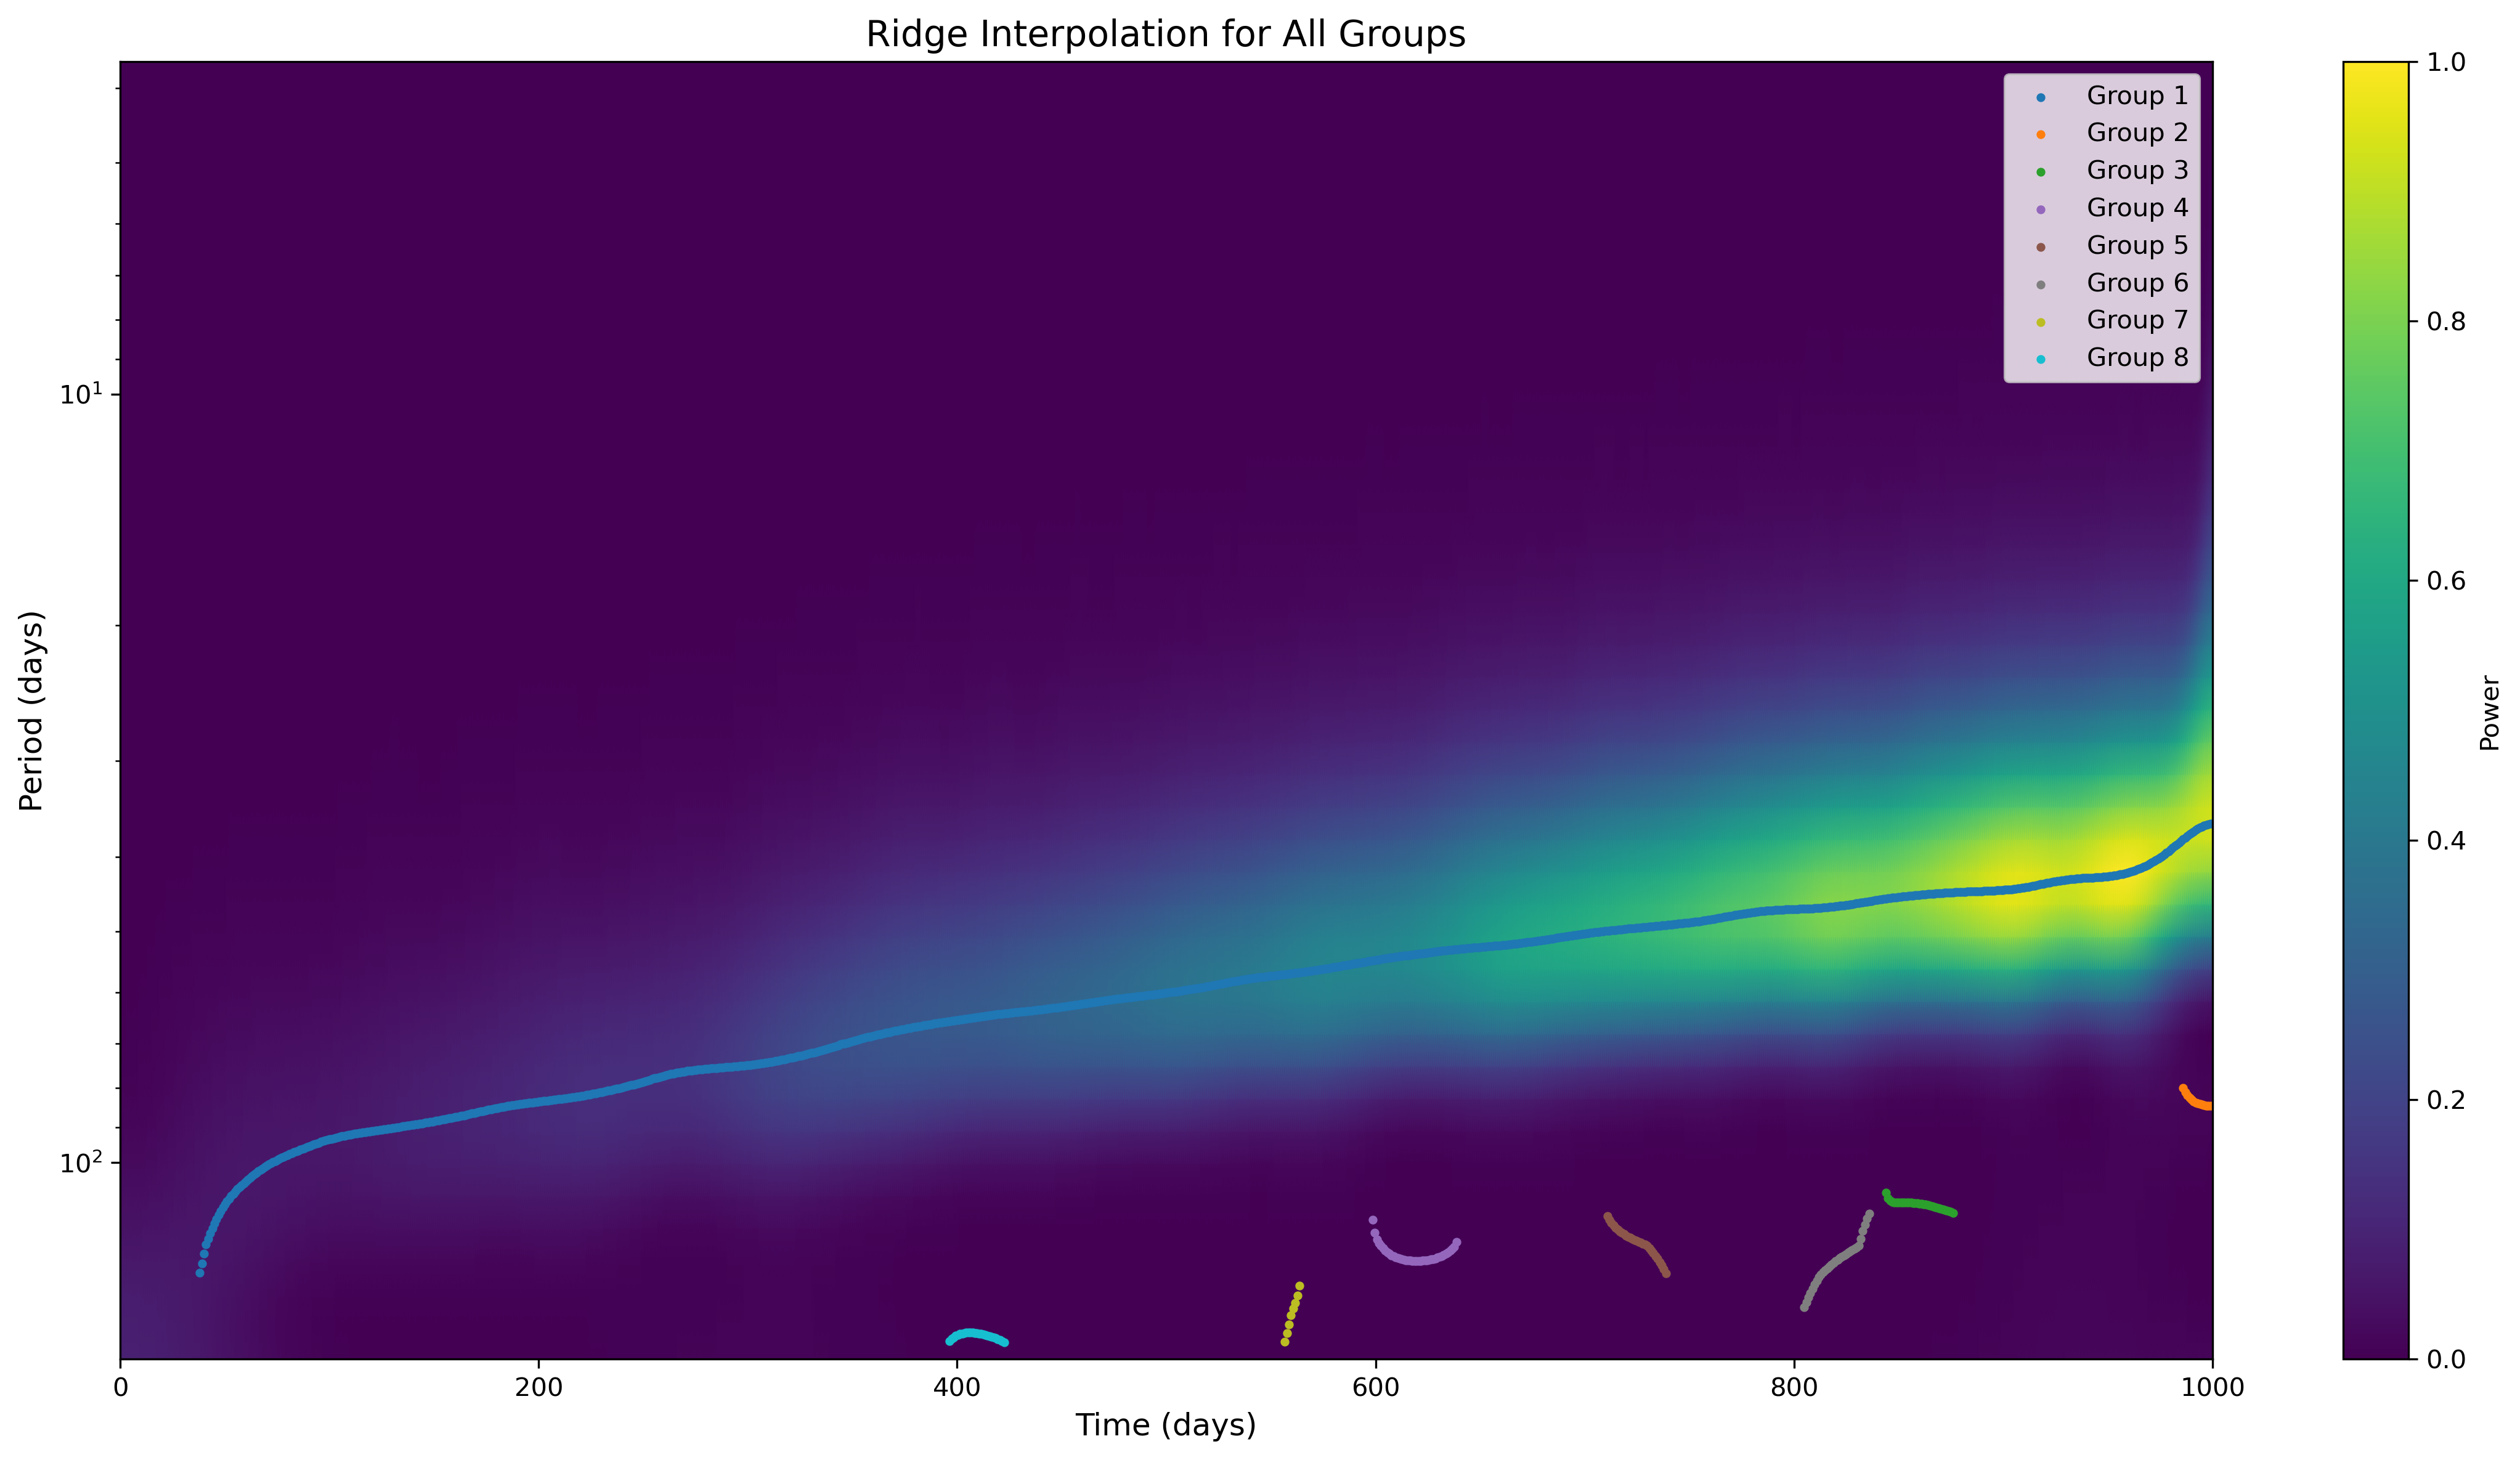

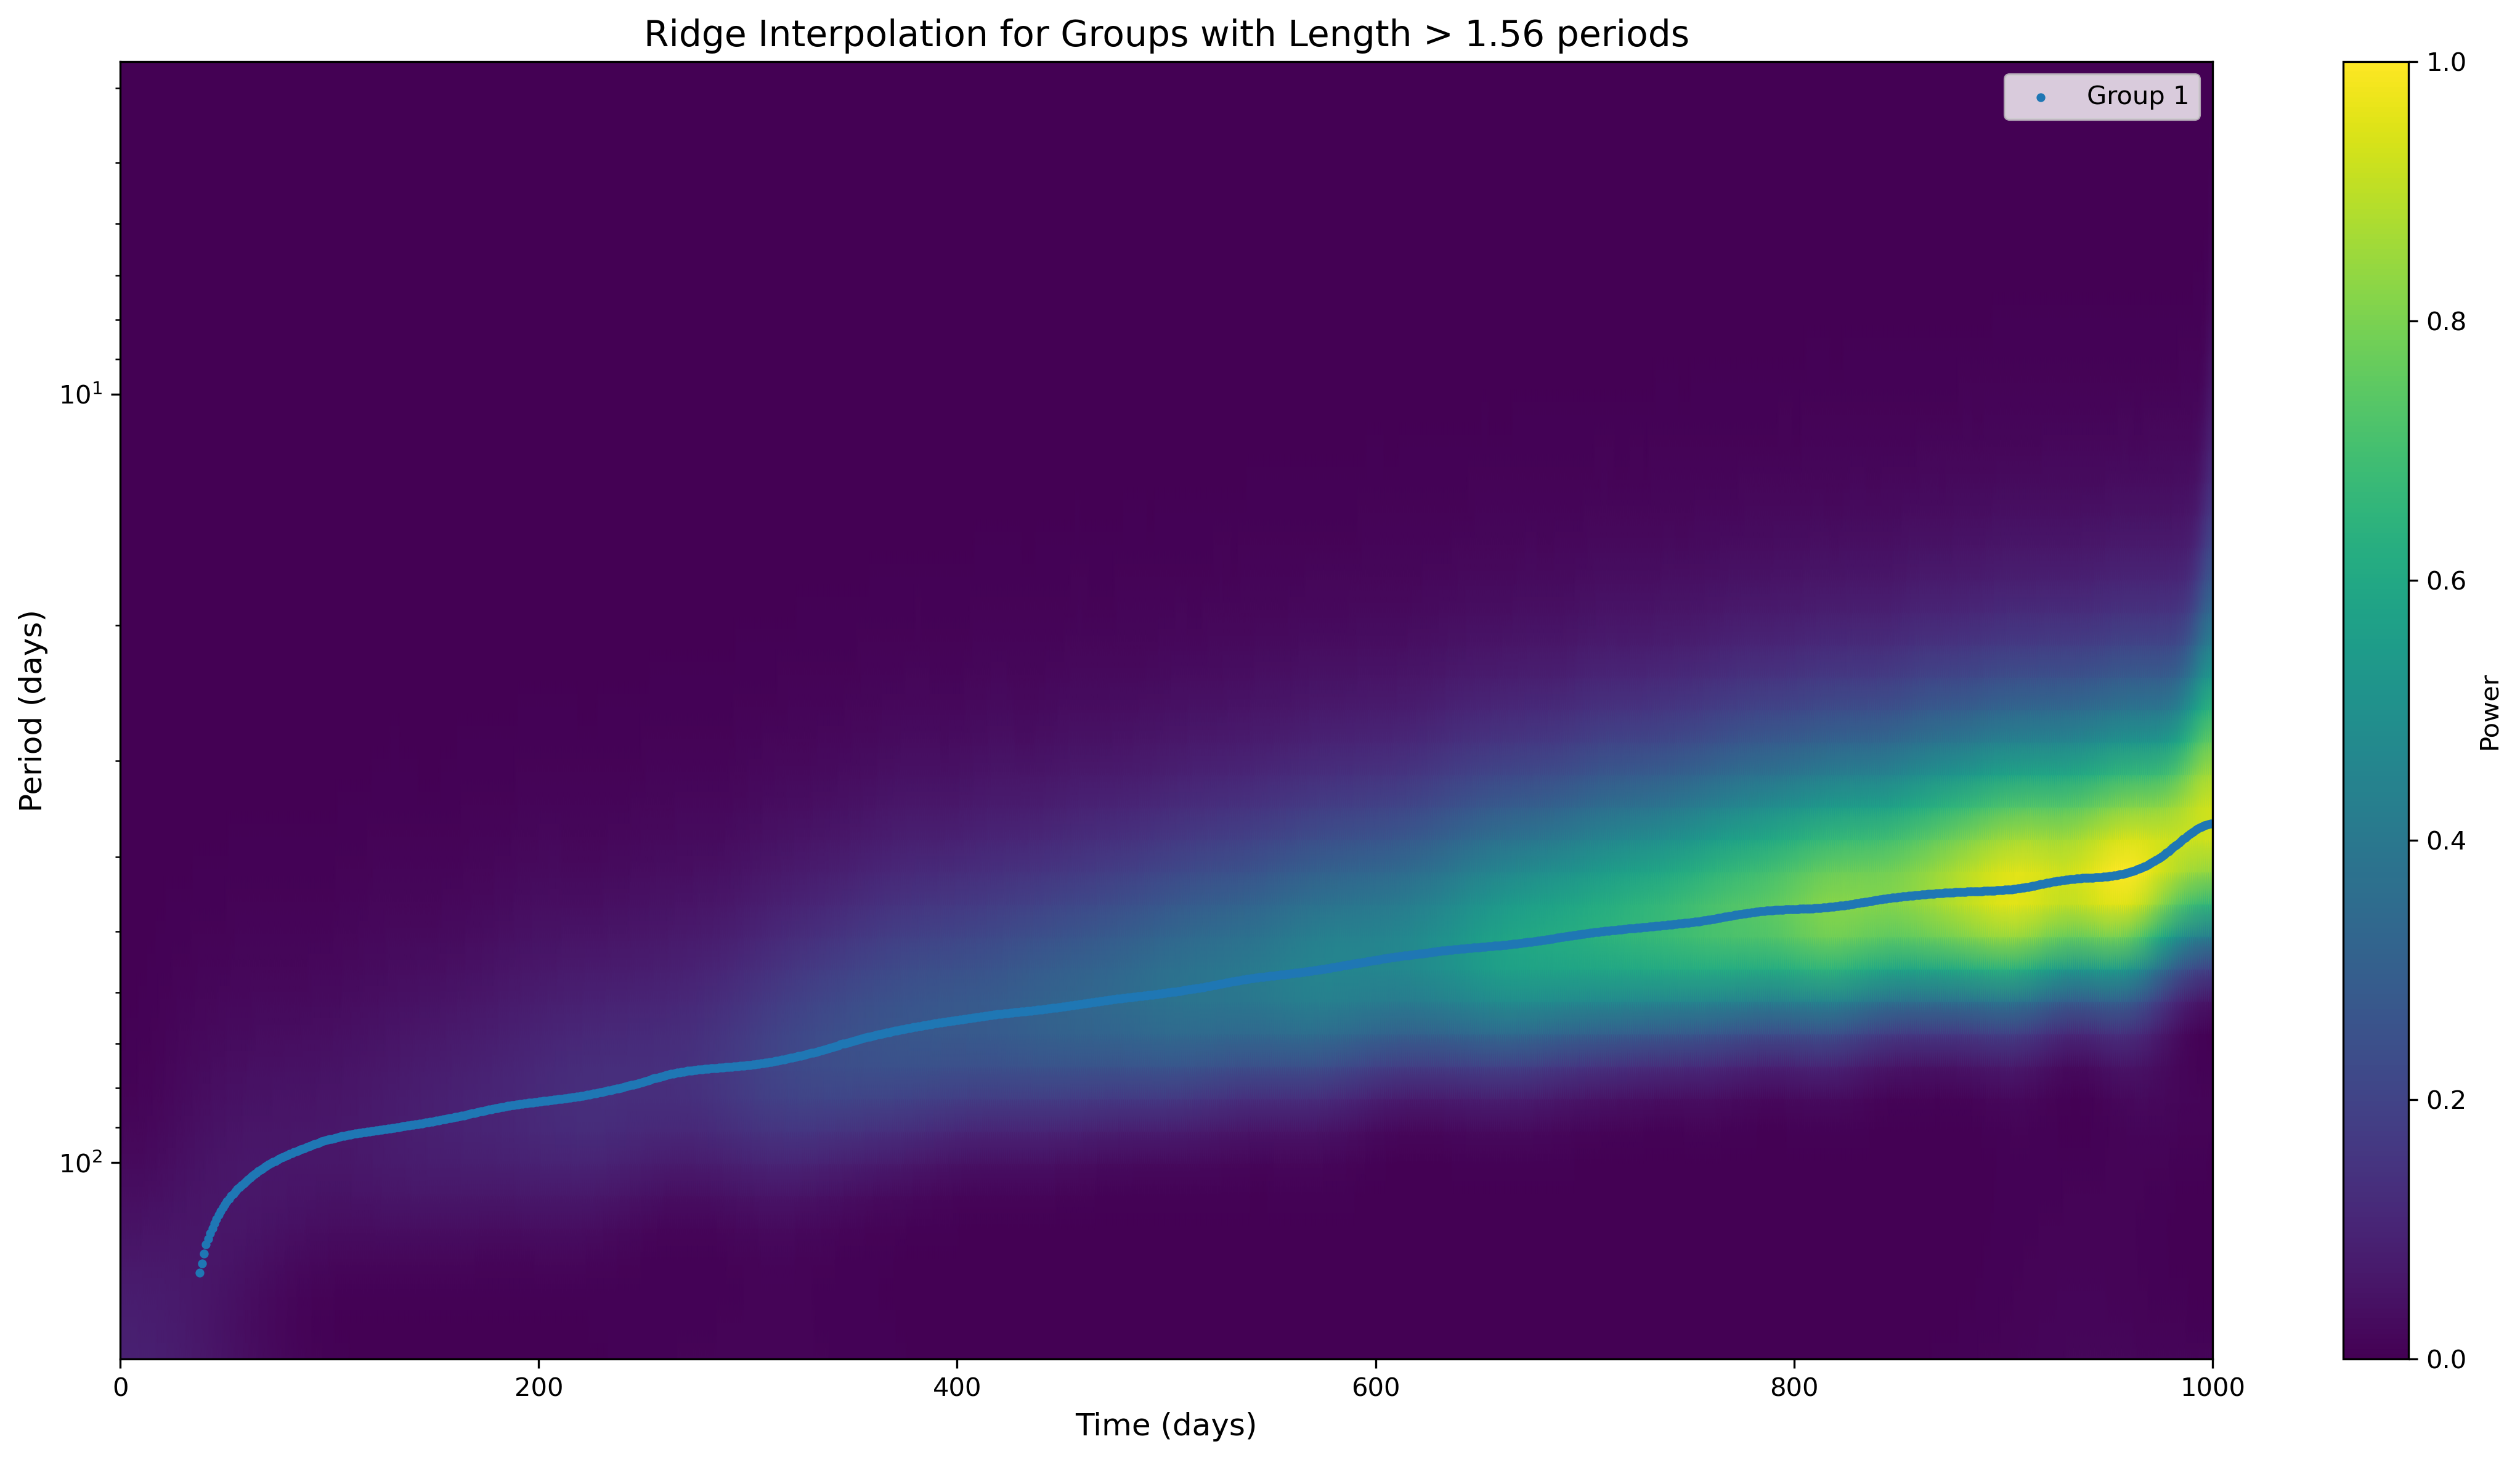

In [20]:
# Create empty lists to store group data
group_lengths = []
group_data = []

# Process each group using coordinate-based approach
for group_id in range(1, num_groups + 1):
    # Extract ridge mask for the group
    group_mask = (labeled_ridges == group_id)
    
    # Create frequency meshgrid to match the transform
    freq_mesh = np.zeros_like(ridge_quantity)
    for i, f in enumerate(freqs):
        freq_mesh[i, :] = f

    # Apply ridge_shift_interpolation to get coordinate-based data
    group_ridge_data = ridge_shift_interpolation(
        ridge_points=group_mask,
        ridge_quantity=power,
        y_arrays=[power, freq_mesh, inst_frequency]
    )
    
    # Store the ridge data for this group
    group_data.append(group_ridge_data)
    
    # Get indices and values from coordinate-based format
    freq_indices, time_indices = group_ridge_data['indices']
    interpolated_power = group_ridge_data['values'][0]
    interpolated_freq = group_ridge_data['values'][1]
    interpolated_inst_frequency = group_ridge_data['values'][2]

    # Skip if group is empty
    if len(freq_indices) == 0:
        group_lengths.append(0)
        continue
    
    # Calculate the length of the group using Simpson's rule
    try:
        group_length = np.abs(integrate.simpson(
            interpolated_freq, 
            x=t[time_indices]
        )) / (2*np.pi)
        group_lengths.append(group_length)
        print(f"Group {group_id} length: {group_length:.2f} periods")
    except Exception as e:
        print(f"Error calculating length for group {group_id}: {e}")
        group_lengths.append(0)

# Create visualization for all groups with coordinate-based data
plt.figure(figsize=(15, 8), dpi=300)
plt.pcolormesh(t, periods, power, shading='gouraud', cmap='viridis')

# Plot each group's ridge points
for group_id in range(1, num_groups + 1):
    # Get color
    color_idx = (group_id - 1) % len(colors)
    color = colors[color_idx]
    
    # Get the ridge data in coordinate format
    ridge_data = group_data[group_id - 1]
    freq_indices, time_indices = ridge_data['indices']
    interpolated_freq = ridge_data['values'][1]

    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
        
    # Calculate period values from frequency values
    period_values = 2.0*np.pi / interpolated_freq
    
    # Plot interpolated ridge points
    plt.scatter(t[time_indices], period_values, 
                color=color, s=15, marker='.', linewidth=1.5, 
                label=f"Group {group_id}" if group_id <= 10 else "")

# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.colorbar(label='Power')
plt.title(f'Ridge Interpolation for All Groups', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Period (days)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()
plt.close()

# Plot only the group with lengths above the minimum threshold

# Calculate minimum length threshold
min_length = 1.0*(2.0*np.sqrt(beta*gamma)/np.pi)# Define Morse wavelet parameters

# Plot the groups with lengths above the threshold
plt.figure(figsize=(15, 8), dpi=300)
plt.pcolormesh(t, periods, power, shading='gouraud', cmap='viridis')

# Plot each group's ridge points
for group_id in range(1, num_groups + 1):
    # Get color
    color_idx = (group_id - 1) % len(colors)
    color = colors[color_idx]
    
    # Get the ridge data in coordinate format
    ridge_data = group_data[group_id - 1]
    freq_indices, time_indices = ridge_data['indices']
    interpolated_freq = ridge_data['values'][1]
    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
        
    # Calculate period values from frequency values
    period_values = 2.0*np.pi / interpolated_freq
    
    # Check length condition
    if group_lengths[group_id - 1] > min_length:
        # Plot interpolated ridge points
        plt.scatter(t[time_indices], period_values, 
                    color=color, s=15, marker='.', linewidth=1.5, 
                    label=f"Group {group_id}" if group_id <= 10 else "")

# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.colorbar(label='Power')
plt.title(f'Ridge Interpolation for Groups with Length > {min_length:.2f} periods', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Period (days)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()
plt.close()


Total ridge points: 1115
Time range: 0 to 999
Frequency range: 0.05 to 0.17
Points per time step - min: 1, max: 2, avg: 1.2
No valid matches between time 7 and 52 (alpha=0.5)
Created 9 groups (min size: 5)


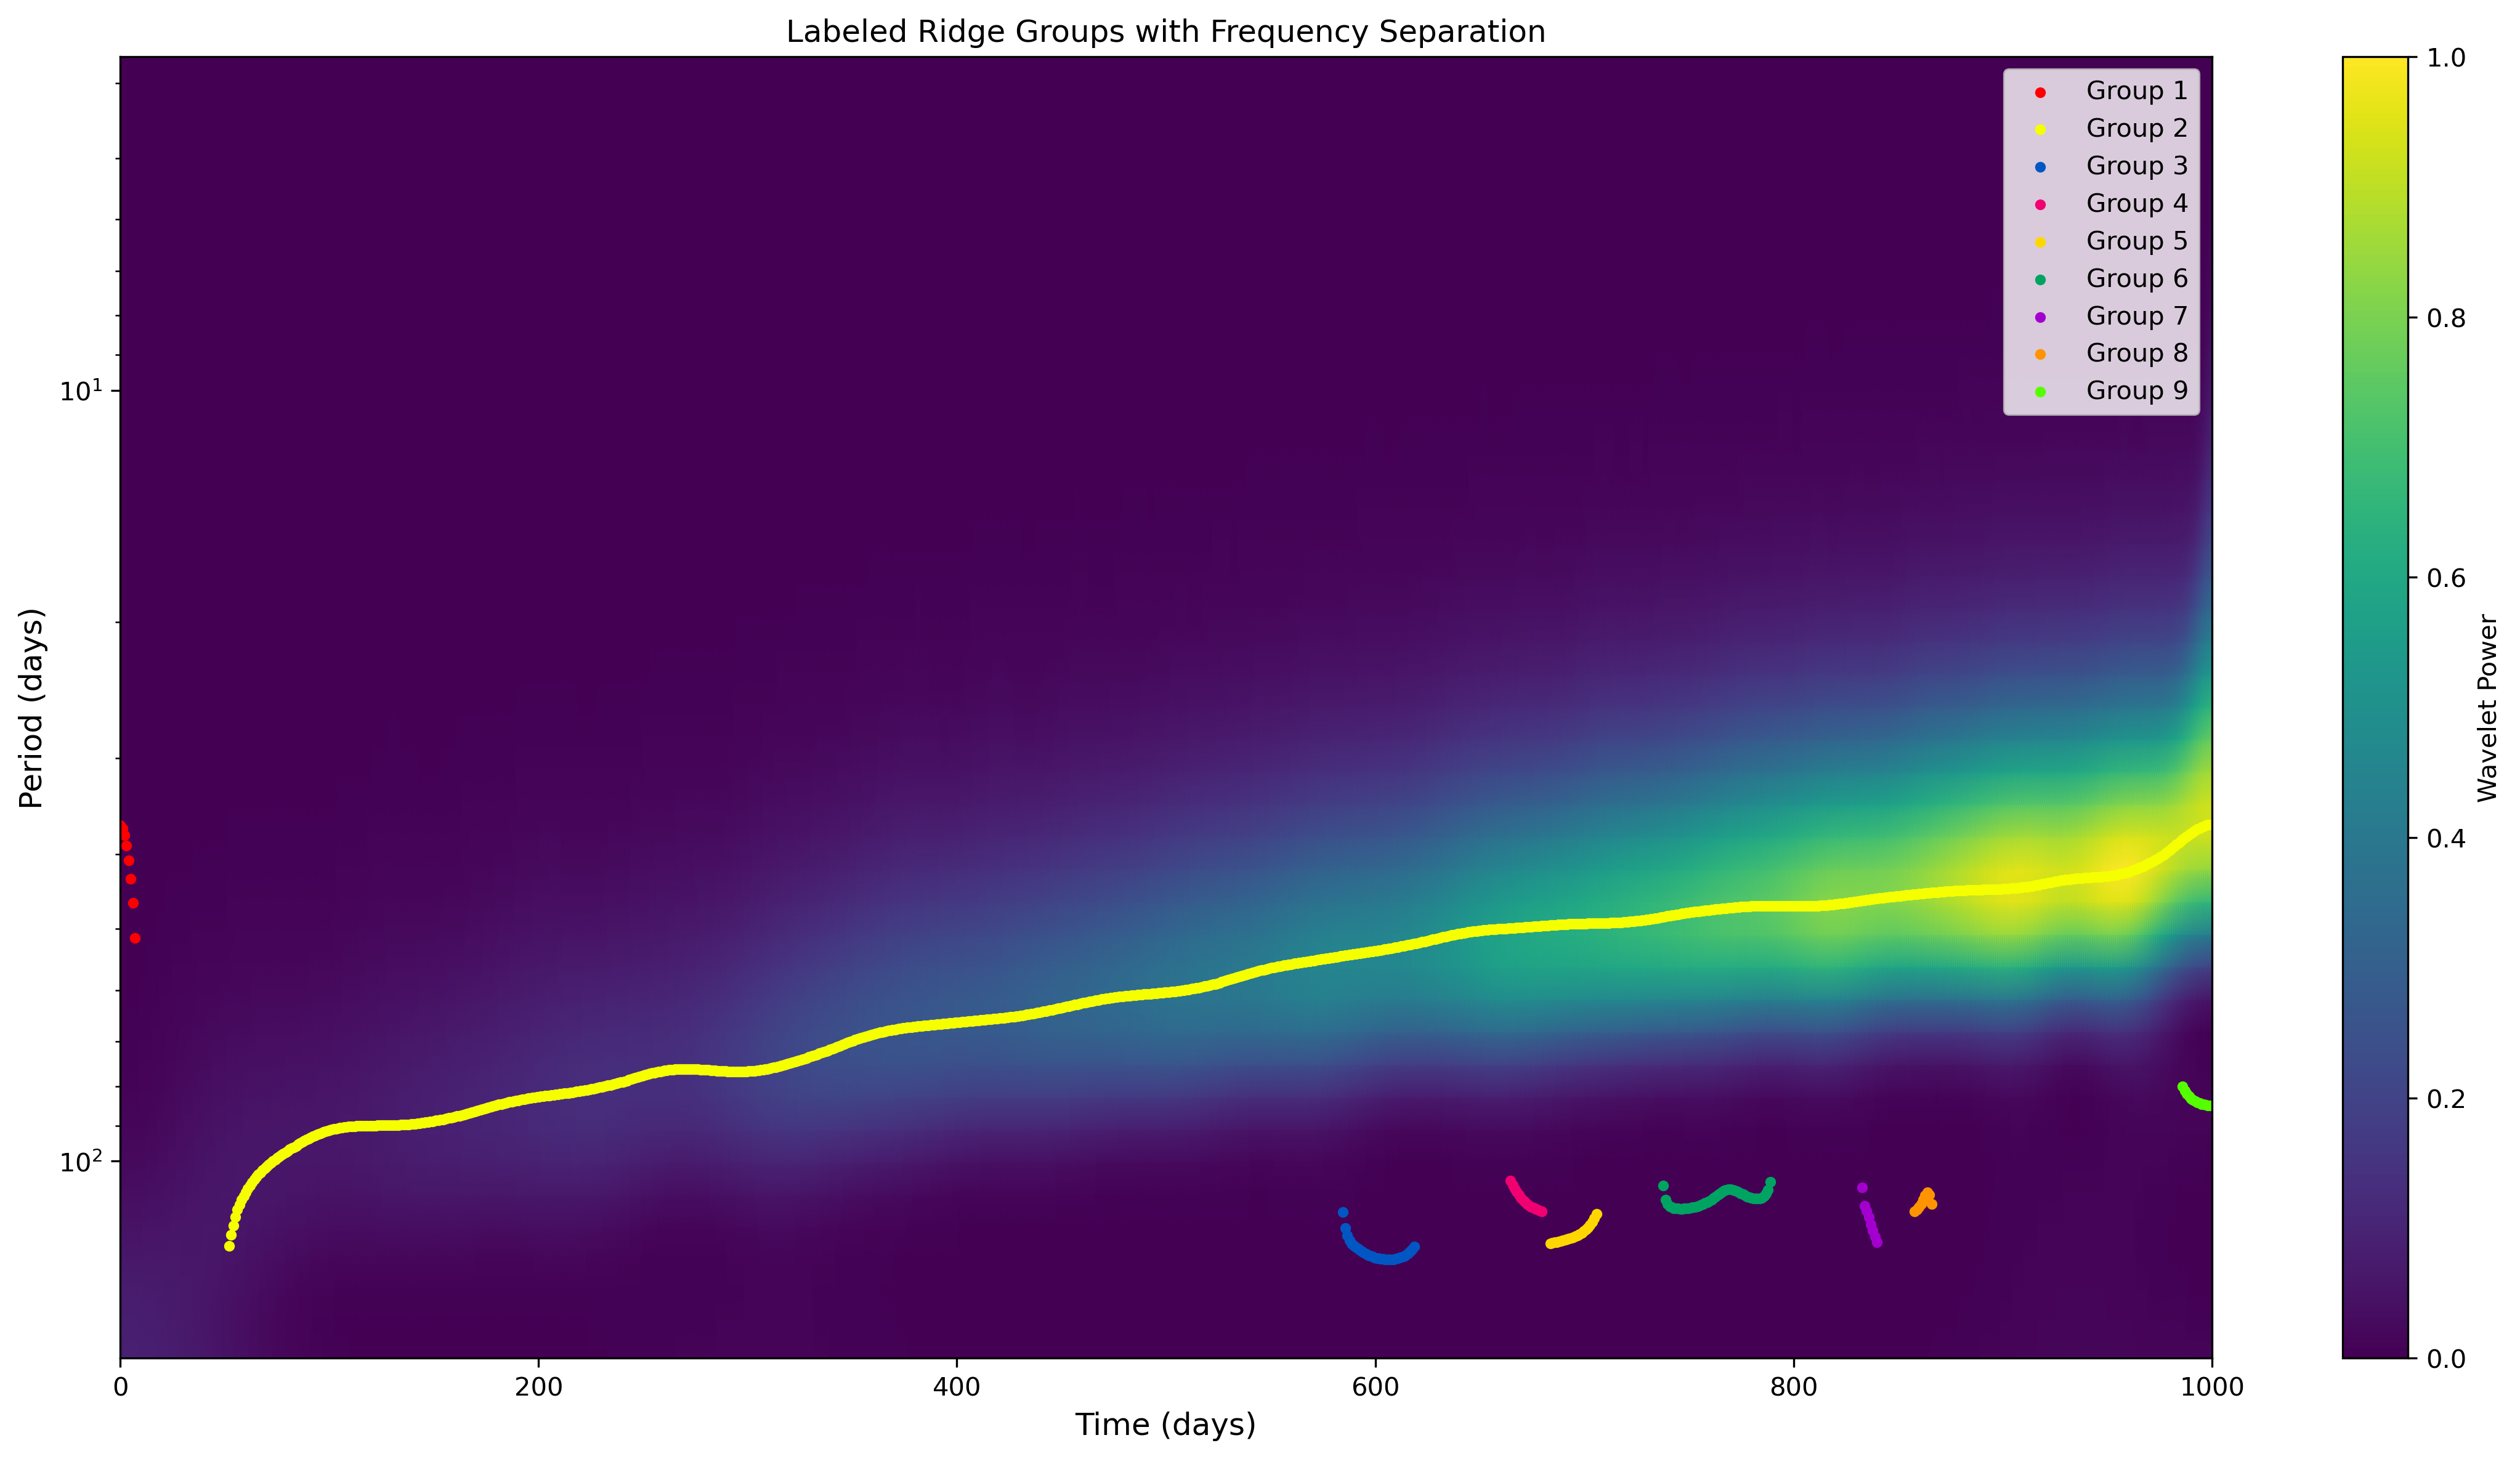

In [21]:
# Calculate the power of the wavelet transform
power = np.abs(wavelet_x)**2 + np.abs(wavelet_y)**2

# Find ridge points
ridge_points, ridge_quantity, processed_transform, inst_frequency = isridgepoint(
    wavelet_transform=wavelet_x,
    scale_frequencies=freqs,
    amplitude_threshold=0.1,
    ridge_type='amplitude'
)

# Create frequency meshgrid for interpolation data
freq_mesh = np.zeros_like(power)
for i, f in enumerate(freqs):
    freq_mesh[i, :] = f

# Calculate the derivative of the instantaneous frequency
inst_frequency_derivative = np.gradient(inst_frequency, axis=0)  # Use axis=0 for time derivative

# Use ridge_shift_interpolation to get better accuracy and include derivative
ridge_data = ridge_shift_interpolation(
    ridge_points=ridge_points,
    ridge_quantity=ridge_quantity,
    y_arrays=[ridge_quantity, freq_mesh, inst_frequency, inst_frequency_derivative]
)

# Group the ridge points with new function that returns group dictionary
group_dict, num_groups = separate_ridge_groups_frequency(
    ridge_data=ridge_data,
    alpha=0.5,           # Physical frequency tolerance 
    min_group_size=5,    # Minimum points per group
    max_gap=2            # Allow gaps of up to 2 time steps
)

# Plot the different ridge groups along with the original power
plt.figure(figsize=(15, 8), dpi=300)
plt.pcolormesh(t, periods, power, shading='gouraud', cmap='viridis')

# Create a array of colors for the groups
colors = cm.prism(np.linspace(0, 1, num_groups))

for group_id in range(1, num_groups + 1):
    # Get the coordinates of the points in this group
    group_quants = group_dict[group_id]
    freq_indices, time_indices = group_quants['indices']
    frequency_values = group_quants['values'][1]

    # Calculate period values from frequency values
    period_values = 2.0*np.pi / frequency_values

    # Plot the points in this group
    plt.scatter(t[time_indices], period_values, color=colors[group_id-1], s=10, label=f'Group {group_id}')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.title("Labeled Ridge Groups with Frequency Separation")
plt.colorbar(label='Wavelet Power')
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Period (days)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()
plt.close()


In [22]:
def detect_and_process_ridges(
    power, freqs, t, 
    amplitude_threshold=0.1, 
    eps=5.0, 
    min_samples=10, 
    scale_factor=1.0
):
    """
    Detect ridge points in wavelet transform, separate them into groups,
    and calculate properties for each group using the memory-efficient coordinate format.
    
    Parameters
    ----------
    power : ndarray
        Wavelet power or amplitude
    freqs : ndarray
        Frequency values corresponding to rows in power
    t : ndarray
        Time values corresponding to columns in power
    amplitude_threshold : float, optional
        Threshold for ridge detection, default=0.1
    eps : float, optional
        DBSCAN epsilon parameter for group separation, default=5.0
    min_samples : int, optional
        DBSCAN minimum samples parameter, default=10
    scale_factor : float, optional
        Factor to scale frequency dimension in DBSCAN, default=1.0
        
    Returns
    -------
    dict
        Dictionary containing:
        - 'ridge_points': Boolean mask of ridge points
        - 'ridge_quantity': Quantity used for ridge detection
        - 'labeled_ridges': Integer array of group labels
        - 'num_groups': Number of groups found
        - 'group_lengths': List of calculated group lengths
        - 'group_data': List of dictionaries with coordinate-based data for each group
        - 'inst_frequency': Instantaneous frequency array
    """
    
    # Find ridge points
    ridge_points, ridge_quantity, processed_transform, inst_frequency = isridgepoint(
        wavelet_transform=power,
        scale_frequencies=freqs,
        amplitude_threshold=amplitude_threshold,
        ridge_type='amplitude'
    )

    # Separate ridge points into groups
    labeled_ridges, num_groups = separate_ridge_groups_dbscan(
        ridge_points, 
        eps=eps,
        min_samples=min_samples,
        scale_factor=scale_factor
    )

    # Create frequency meshgrid to match the transform
    freq_mesh = np.zeros_like(ridge_quantity)
    for i, f in enumerate(freqs):
        freq_mesh[i, :] = f
        
    # Create empty lists to store group data
    group_lengths = []
    group_data = []

    # Loop through each group and process
    for group_id in range(1, num_groups + 1):
        # Extract ridge mask for the group
        group_mask = (labeled_ridges == group_id)

        # Apply ridge_shift_interpolation to get coordinate-based data
        group_ridge_data = ridge_shift_interpolation(
            ridge_points=group_mask,
            ridge_quantity=ridge_quantity,
            y_arrays=[ridge_quantity, freq_mesh, inst_frequency]
        )
        
        # Get indices from coordinate format
        freq_indices, time_indices = group_ridge_data['indices']
        
        # Store the ridge data for this group
        group_data.append(group_ridge_data)
        
        # Skip if group is empty
        if len(freq_indices) == 0:
            group_lengths.append(0)
            continue

        # Extract interpolated frequency values directly from the values list
        interpolated_freq_values = group_ridge_data['values'][2]
        
        # Calculate the length of the group using Simpson's rule
        try:
            group_length = np.abs(integrate.simpson(
                interpolated_freq_values, 
                x=t[time_indices]
            )) / (2*np.pi)
            group_lengths.append(group_length)
        except Exception as e:
            print(f"Error calculating length for group {group_id}: {e}")
            group_lengths.append(0)

    return {
        'ridge_points': ridge_points,
        'ridge_quantity': ridge_quantity,
        'labeled_ridges': labeled_ridges,
        'num_groups': num_groups,
        'group_lengths': group_lengths,
        'group_data': group_data,
        'inst_frequency': inst_frequency
    }

# Get a single drifter from the gdp1h dataset
# Load the drifter data
ds = gdp1h()

traj_idx = cd.ragged.rowsize_to_index(ds["rowsize"])

n = 44000
j = int(np.where(ds["id"]==n)[0][0])
print('drifter index for `id` '+str(n)+' is '+str(j))

# peak at the some SST data for this drifter
ds.sst1[slice(traj_idx[j], traj_idx[j+1])]
sli = slice(traj_idx[j], traj_idx[j+1])

lat = ds.lat[sli].values
lon = ds.lon[sli].values

# convert to displacements starting from the first point, accounting for curvature
x_t = (lon-lon[0])*np.cos(np.radians(lat[0]))*6378.0
y_t = (lat-lat[0])*6378.0

# Get time in days
t = ds.time[sli].values

# Convert from nanosecond to hours
t = t.astype(float)
t = t / 1e9 / 3600.0

t = t - t[0]

# Define Morse wavelet parameters
gamma = 3  # Controls time-frequency resolution trade-off
beta = 2   # Controls shape/symmetry of the wavelet

# Generate logarithmically spaced frequencies for analysis
freqs = morse_logspace_freq(gamma, beta, len(t), density=4)

# Calculate the coriolis frequency
coriolis_freq = coriolis_frequency(lat)

# Convert Coriolis frequency to radians per hour
coriolis_freq_rad = coriolis_freq * 3600

# Convert coriolis frequency to period
coriolis_period = 2.0*np.pi / coriolis_freq_rad

# Apply the Morse wavelet transform
wavelet_plus = morse_wavelet_transform(x_t + 1j*y_t, gamma, beta, freqs, boundary="mirror")
wavelet_minus = morse_wavelet_transform(x_t - 1j*y_t, gamma, beta, freqs, boundary="mirror")

power_minus = np.abs(wavelet_minus)
power_plus = np.abs(wavelet_plus)

# Convert from frequencies to periods for plotting
periods = 2.0*np.pi / freqs

# Process ridges with the optimized function
ridge_results_plus = detect_and_process_ridges(
    wavelet_plus, freqs, t, 
    amplitude_threshold=0.5, 
    eps=5.0, 
    min_samples=10, 
    scale_factor=1.0,
)
ridge_results_minus = detect_and_process_ridges(
    wavelet_minus, freqs, t, 
    amplitude_threshold=0.5, 
    eps=5.0, 
    min_samples=10, 
    scale_factor=1.0,
)

# Extract basic results
labeled_ridges_plus = ridge_results_plus['labeled_ridges']
labeled_ridges_minus = ridge_results_minus['labeled_ridges']
num_groups_plus = ridge_results_plus['num_groups']
num_groups_minus = ridge_results_minus['num_groups']
group_lengths_plus = ridge_results_plus['group_lengths']
group_lengths_minus = ridge_results_minus['group_lengths']
ridge_quantity_plus = ridge_results_plus['ridge_quantity']
ridge_quantity_minus = ridge_results_minus['ridge_quantity']
inst_frequency_plus = ridge_results_plus['inst_frequency']
inst_frequency_minus = ridge_results_minus['inst_frequency']

# Extract group data (coordinate-based format)
group_data_plus = ridge_results_plus['group_data']
group_data_minus = ridge_results_minus['group_data']

# Calculate minimum length thresholds
min_length = 1.0 * (2.0 * np.sqrt(beta * gamma) / np.pi)
print(f"Minimum length for groups: {min_length:.2f} periods")

# Filter out groups with length less than min_length
filtered_group_ids_plus = [i+1 for i, length in enumerate(group_lengths_plus) if length >= min_length]
filtered_group_ids_minus = [i+1 for i, length in enumerate(group_lengths_minus) if length >= min_length]

# Print statistics
print(f"Plus transform groups: {num_groups_plus} total, {len(filtered_group_ids_plus)} filtered")
print(f"Minus transform groups: {num_groups_minus} total, {len(filtered_group_ids_minus)} filtered")


drifter index for `id` 44000 is 1757
Minimum length for groups: 1.56 periods
Plus transform groups: 506 total, 58 filtered
Minus transform groups: 597 total, 75 filtered


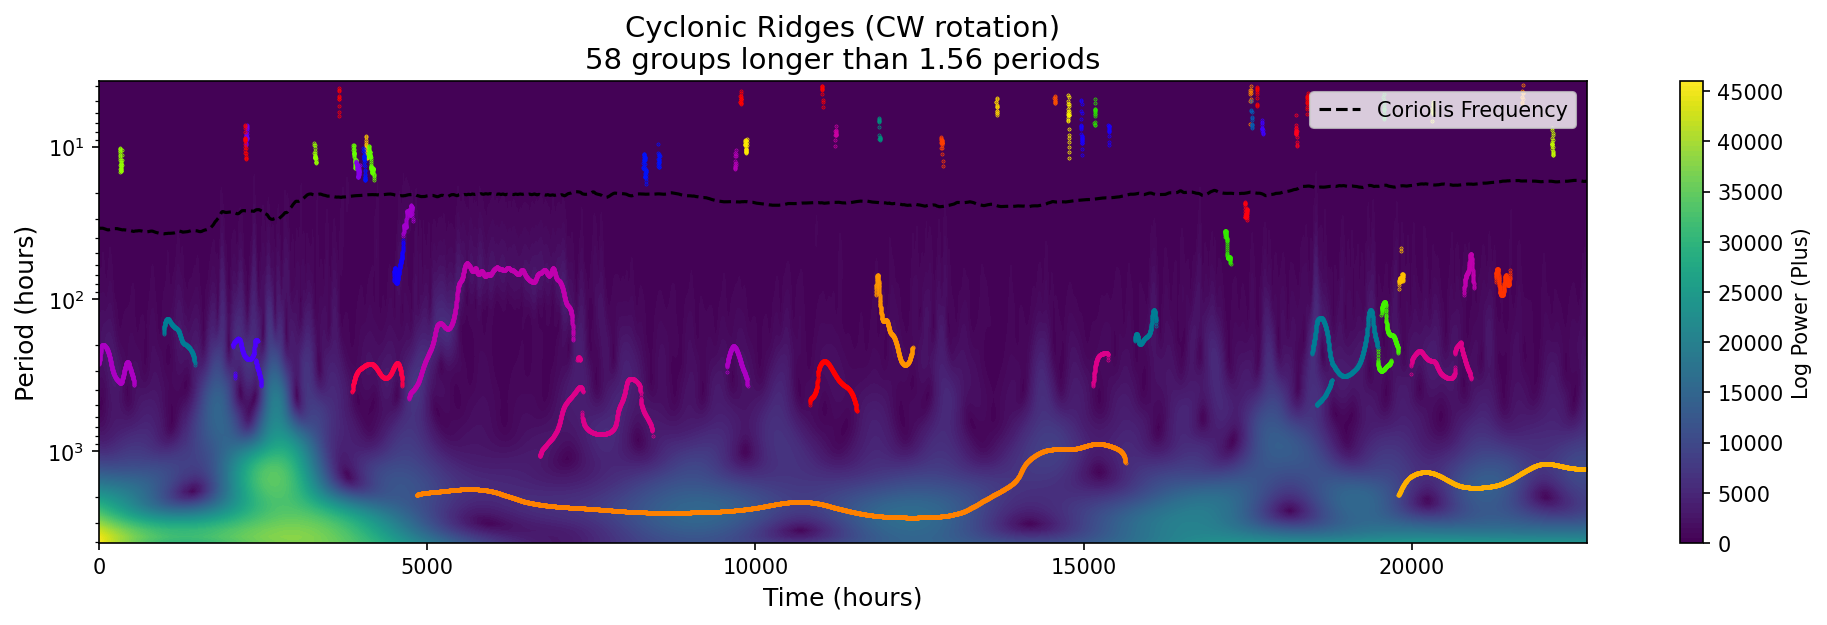

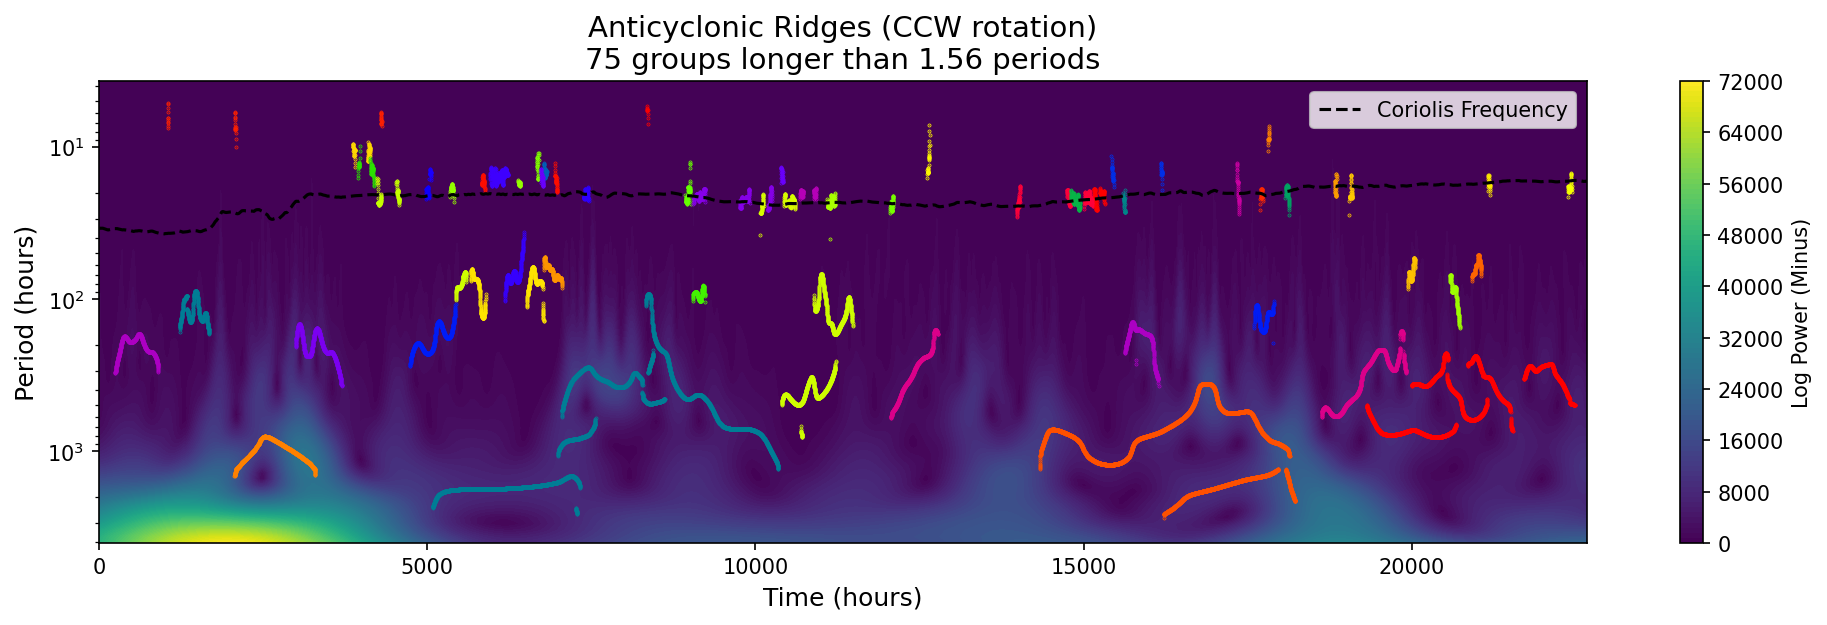

In [23]:
def wavelet_contourf(ax, time, frequencies, wavelet_coefficients, power=1, **contourf_args):
    time = np.asarray(time)
    frequencies = np.asarray(frequencies)
    wavelet_coefficients = np.asarray(wavelet_coefficients)
    if time.ndim != 1:
        raise ValueError('Expected 1d array for time')
    if frequencies.ndim != 1:
        raise ValueError('Expected 1d array for frequencies')
    if wavelet_coefficients.ndim != 2:
        raise ValueError('Expected 2d array for wavelet_coefficients')
    if wavelet_coefficients.shape != (len(frequencies), len(time)):
        raise ValueError('Expected wavelet_coefficients to have shape ({}, {}). Actual shape: {}'.format(
            len(frequencies), len(time), wavelet_coefficients.shape))
    if not np.isrealobj(wavelet_coefficients) or power != 1:
        wavelet_coefficients = np.abs(wavelet_coefficients)
    if power != 1:
        wavelet_coefficients = np.power(wavelet_coefficients, power)
    time, frequencies = np.meshgrid(time, frequencies)
    return ax.contourf(time, frequencies, wavelet_coefficients, **contourf_args)

# Helper function to get group data
def get_group_data(group_data_list, group_id, data_index=1):
    """
    Extract data for a specific group in coordinate format.
    
    Parameters:
    -----------
    group_data_list : list
        List of group data dictionaries
    group_id : int
        1-based index of the group
    data_index : int, optional
        Index of the data to retrieve (0=ridge_quantity, 1=frequency, 2=inst_frequency)
    
    Returns:
    --------
    tuple: (freq_indices, time_indices, values)
    """
    group_data = group_data_list[group_id - 1]
    freq_indices, time_indices = group_data['indices']
    values = group_data['values'][data_index]
    return freq_indices, time_indices, values 

# Create a new figure with both wavelet transforms
plt.figure(figsize=(16, 4), dpi=150)
colors_plus = cm.prism(np.linspace(0, 1, num_groups_plus*2))

# Plot "plus" wavelet power as background
cax_plus = wavelet_contourf(
    plt.gca(), t, periods, power_plus, levels=100
)

# Loop through each filtered "plus" group
for group_id in filtered_group_ids_plus:
    # Get the ridge data in coordinate format
    freq_indices, time_indices, freq_values = get_group_data(
        group_data_plus, group_id, data_index=1  # 1 is the index for frequency values
    )
    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
    
    # Get color
    color_idx = (group_id - 1) % len(colors_plus)
    color = colors_plus[color_idx]
        
    # Calculate interpolated period values
    interp_period_values = 2.0 * np.pi / freq_values

    # Plot interpolated ridge points
    plt.scatter(t[time_indices], interp_period_values, 
                color=color, s=0.5, marker='.', linewidth=1.5)

# Plot Coriolis frequency
plt.plot(t, coriolis_period, color='black', linestyle='--', linewidth=1.5, label='Coriolis Frequency')

# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.colorbar(cax_plus, label='Log Power (Plus)')
plt.title(f'Cyclonic Ridges (CW rotation)\n{len(filtered_group_ids_plus)} groups longer than {min_length:.2f} periods', fontsize=14)
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Period (hours)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.show()
plt.close()

# Create a new figure for minus transform
plt.figure(figsize=(16, 4), dpi=150)
colors_minus = cm.prism(np.linspace(0, 1, num_groups_minus*2))

# Plot "minus" wavelet power as background
cax_minus = wavelet_contourf(
    plt.gca(), t, periods, power_minus, levels=100
)

# Loop through each filtered "minus" group
for group_id in filtered_group_ids_minus:
    # Get the ridge data in coordinate format
    freq_indices, time_indices, freq_values = get_group_data(
        group_data_minus, group_id, data_index=1  # 1 is the index for frequency values
    )
    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
    
    # Get color
    color_idx = (group_id - 1) % len(colors_minus)
    color = colors_minus[color_idx]
        
    # Calculate interpolated period values
    interp_period_values = 2.0 * np.pi / freq_values

    # Plot interpolated ridge points
    plt.scatter(t[time_indices], interp_period_values, 
                color=color, s=0.5, marker='.', linewidth=1.5)

# Plot Coriolis frequency
plt.plot(t, coriolis_period, color='black', linestyle='--', linewidth=1.5, label='Coriolis Frequency')

# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.colorbar(cax_minus, label='Log Power (Minus)')
plt.title(f'Anticyclonic Ridges (CCW rotation)\n{len(filtered_group_ids_minus)} groups longer than {min_length:.2f} periods', fontsize=14)
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Period (hours)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.show()
plt.close()

In [24]:
def detect_and_process_ridges(
    power, freqs, t, 
    amplitude_threshold=0.1, 
    alpha=2.0,
    min_group_size=5, 
    max_gap=2
):
    """
    Detect ridge points in wavelet transform, separate them into groups using frequency prediction,
    and calculate properties for each group using the coordinate-based format.
    
    Parameters
    ----------
    power : ndarray
        Wavelet power or amplitude
    freqs : ndarray
        Frequency values corresponding to rows in power
    t : ndarray
        Time values corresponding to columns in power
    amplitude_threshold : float, optional
        Threshold for ridge detection, default=0.1
    alpha : float, optional
        Maximum allowed frequency difference for matching points, default=2.0
    min_group_size : int, optional
        Minimum number of points for a valid group, default=5
    max_gap : int, optional
        Maximum allowed time gap between ridge points, default=2
        
    Returns
    -------
    dict
        Dictionary containing:
        - 'ridge_points': Boolean mask of ridge points
        - 'ridge_quantity': Quantity used for ridge detection
        - 'num_groups': Number of groups found
        - 'group_lengths': List of calculated group lengths
        - 'group_data': Dictionary of group data with frequency-based interpolation
        - 'inst_frequency': Instantaneous frequency array
    """
    
    # Find ridge points
    ridge_points, ridge_quantity, processed_transform, inst_frequency = isridgepoint(
        wavelet_transform=power,
        scale_frequencies=freqs,
        amplitude_threshold=amplitude_threshold,
        ridge_type='amplitude'
    )

    # Create frequency meshgrid for interpolation data
    freq_mesh = np.zeros_like(ridge_quantity)
    for i, f in enumerate(freqs):
        freq_mesh[i, :] = f
        
    # Calculate the derivative of the instantaneous frequency
    inst_frequency_derivative = np.gradient(inst_frequency, axis=0)
    
    # Use ridge_shift_interpolation to get better accuracy and include derivative
    ridge_data = ridge_shift_interpolation(
        ridge_points=ridge_points,
        ridge_quantity=ridge_quantity,
        y_arrays=[ridge_quantity, freq_mesh, inst_frequency, inst_frequency_derivative]
    )
    
    # Group the ridge points using frequency-based approach
    group_dict, num_groups = separate_ridge_groups_frequency(
        ridge_data=ridge_data,
        alpha=alpha,
        min_group_size=min_group_size,
        max_gap=max_gap
    )
    
    # Calculate lengths for each group
    group_lengths = []
    
    # Process each group to calculate its length
    for group_id in range(1, num_groups + 1):
        # Get group data
        if group_id not in group_dict:
            group_lengths.append(0)
            continue
            
        # Extract frequency values and time indices
        freq_indices, time_indices = group_dict[group_id]['indices']
        freq_values = group_dict[group_id]['values'][2]  # Index 1 contains inst_frequency
        
        # Skip if group is empty
        if len(freq_indices) == 0:
            group_lengths.append(0)
            continue
        
        # Calculate the length of the group using Simpson's rule
        try:
            group_length = np.abs(integrate.simpson(
                freq_values, 
                x=t[time_indices]
            )) / (2*np.pi)
            group_lengths.append(group_length)
        except Exception as e:
            print(f"Error calculating length for group {group_id}: {e}")
            group_lengths.append(0)
    
    return {
        'ridge_points': ridge_points,
        'ridge_quantity': ridge_quantity,
        'num_groups': num_groups,
        'group_lengths': group_lengths,
        'group_data': group_dict,
        'inst_frequency': inst_frequency,
        'ridge_data': ridge_data,
    }

def _cosd(x):
    return np.cos(np.radians(x))

def _sind(x):
    return np.sin(np.radians(x))

def latlon2xy(lat, lon, lat0, lon0):
    x = np.full_like(lat, np.nan)
    y = np.full_like(lon, np.nan)
    # broadcast
    lat0 = np.zeros_like(lat) + lat0
    lon0 = np.zeros_like(lon) + lon0
    cos_lat = _cosd(lat)
    cos_lon = _cosd(lon)
    cos_lat0 = _cosd(lat0)
    sin_lat0 = _sind(lat0)
    sin_lat = _sind(lat)
    indicator = cos_lat * cos_lon * cos_lat0 + sin_lat0 * sin_lat > 0
    radius_earth = 6371
    x[indicator] = radius_earth * cos_lat[indicator] * _sind(lon[indicator])
    y[indicator] = (-radius_earth * cos_lat[indicator] * sin_lat0[indicator] * cos_lon[indicator]
                    + radius_earth * cos_lat0[indicator] * sin_lat[indicator])
    return x, y

# Get a single drifter from the gdp1h dataset
# Load the drifter data
ds = gdp1h()

traj_idx = cd.ragged.rowsize_to_index(ds["rowsize"])

n = 44000
j = int(np.where(ds["id"]==n)[0][0])
print('drifter index for `id` '+str(n)+' is '+str(j))

# peak at the some SST data for this drifter
ds.sst1[slice(traj_idx[j], traj_idx[j+1])]
sli = slice(traj_idx[j], traj_idx[j+1])

lat = ds.lat[sli].values
lon = ds.lon[sli].values

# convert to displacements starting from the first point, accounting for curvature
x_t, y_t = latlon2xy(lat, lon, lat[0], lon[0])

# Get time in days
t = ds.time[sli].values

# Convert from nanosecond to hours
t = t.astype(float)
t = t / 1e9 / 3600.0

t = t - t[0]

# Define Morse wavelet parameters
gamma = 3  # Controls time-frequency resolution trade-off
beta = 2   # Controls shape/symmetry of the wavelet

# Generate logarithmically spaced frequencies for analysis
freqs = morse_logspace_freq(gamma, beta, len(t), density=4)

# Calculate the coriolis frequency
coriolis_freq = coriolis_frequency(lat)

# Convert Coriolis frequency to radians per hour
coriolis_freq_rad = coriolis_freq * 3600

# Convert coriolis frequency to period
coriolis_period = 2.0*np.pi / coriolis_freq_rad

# Apply the Morse wavelet transform
wavelet_plus = morse_wavelet_transform(x_t + 1j*y_t, gamma, beta, freqs, boundary="mirror")
wavelet_minus = morse_wavelet_transform(x_t - 1j*y_t, gamma, beta, freqs, boundary="mirror")

power_minus = np.abs(wavelet_minus)
power_plus = np.abs(wavelet_plus)

# Convert from frequencies to periods for plotting
periods = 2.0*np.pi / freqs

# Process ridges with the new frequency-based approach
ridge_results_plus = detect_and_process_ridges(
    wavelet_plus, freqs, t, 
    amplitude_threshold=0.1, 
    alpha=0.5,           # Physical frequency tolerance
    min_group_size=1,    # Minimum points per group
    max_gap=2            # Maximum allowed time gap
)
ridge_results_minus = detect_and_process_ridges(
    wavelet_minus, freqs, t, 
    amplitude_threshold=0.1, 
    alpha=0.5,
    min_group_size=1,
    max_gap=2
)

# Extract basic results
num_groups_plus = ridge_results_plus['num_groups']
num_groups_minus = ridge_results_minus['num_groups']
group_lengths_plus = ridge_results_plus['group_lengths']
group_lengths_minus = ridge_results_minus['group_lengths']
ridge_quantity_plus = ridge_results_plus['ridge_quantity']
ridge_quantity_minus = ridge_results_minus['ridge_quantity']
inst_frequency_plus = ridge_results_plus['inst_frequency']
inst_frequency_minus = ridge_results_minus['inst_frequency']
ridge_data_plus = ridge_results_plus['ridge_data']
ridge_data_minus = ridge_results_minus['ridge_data']

# Extract group data (now directly in dictionary form)
group_data_plus = ridge_results_plus['group_data']
group_data_minus = ridge_results_minus['group_data']

# Calculate minimum length thresholds
min_length = 0.1 * (2.0 * np.sqrt(beta * gamma) / np.pi)
print(f"Minimum length for groups: {min_length:.2f} periods")

# Filter out groups with length less than min_length
filtered_group_ids_plus = [i+1 for i, length in enumerate(group_lengths_plus) if length >= min_length]
filtered_group_ids_minus = [i+1 for i, length in enumerate(group_lengths_minus) if length >= min_length]

# Print statistics
print(f"Plus transform groups: {num_groups_plus} total, {len(filtered_group_ids_plus)} filtered")
print(f"Minus transform groups: {num_groups_minus} total, {len(filtered_group_ids_minus)} filtered")

drifter index for `id` 44000 is 1757
Total ridge points: 63946
Time range: 0 to 22643
Frequency range: 0.00 to 1.62
Points per time step - min: 1, max: 7, avg: 2.8
Error at time 16: cost matrix is infeasible
Cost matrix shape: (3, 3), min: 0.0015043114544823766, finite values: 2
Error at time 329: cost matrix is infeasible
Cost matrix shape: (4, 4), min: 0.00024412792117800564, finite values: 3
Error at time 649: cost matrix is infeasible
Cost matrix shape: (4, 4), min: 4.0120936318999156e-05, finite values: 3
Error at time 687: cost matrix is infeasible
Cost matrix shape: (4, 4), min: 4.757143688038923e-05, finite values: 3
Error at time 724: cost matrix is infeasible
Cost matrix shape: (4, 4), min: 0.00013070953718852252, finite values: 3
Error at time 770: cost matrix is infeasible
Cost matrix shape: (4, 4), min: 0.00022285011073108763, finite values: 3
Error at time 1300: cost matrix is infeasible
Cost matrix shape: (3, 3), min: 0.0003243873652536422, finite values: 2
Error at time

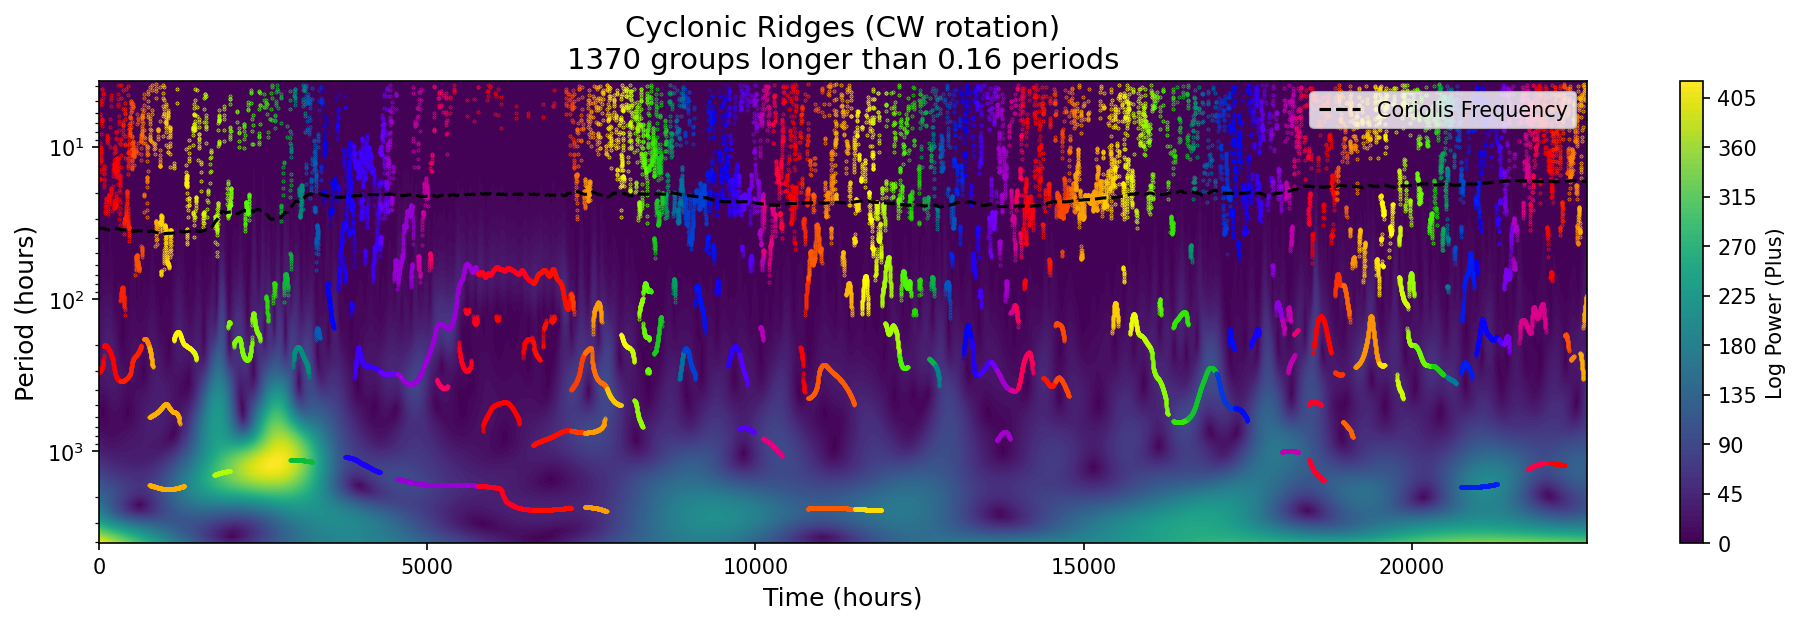

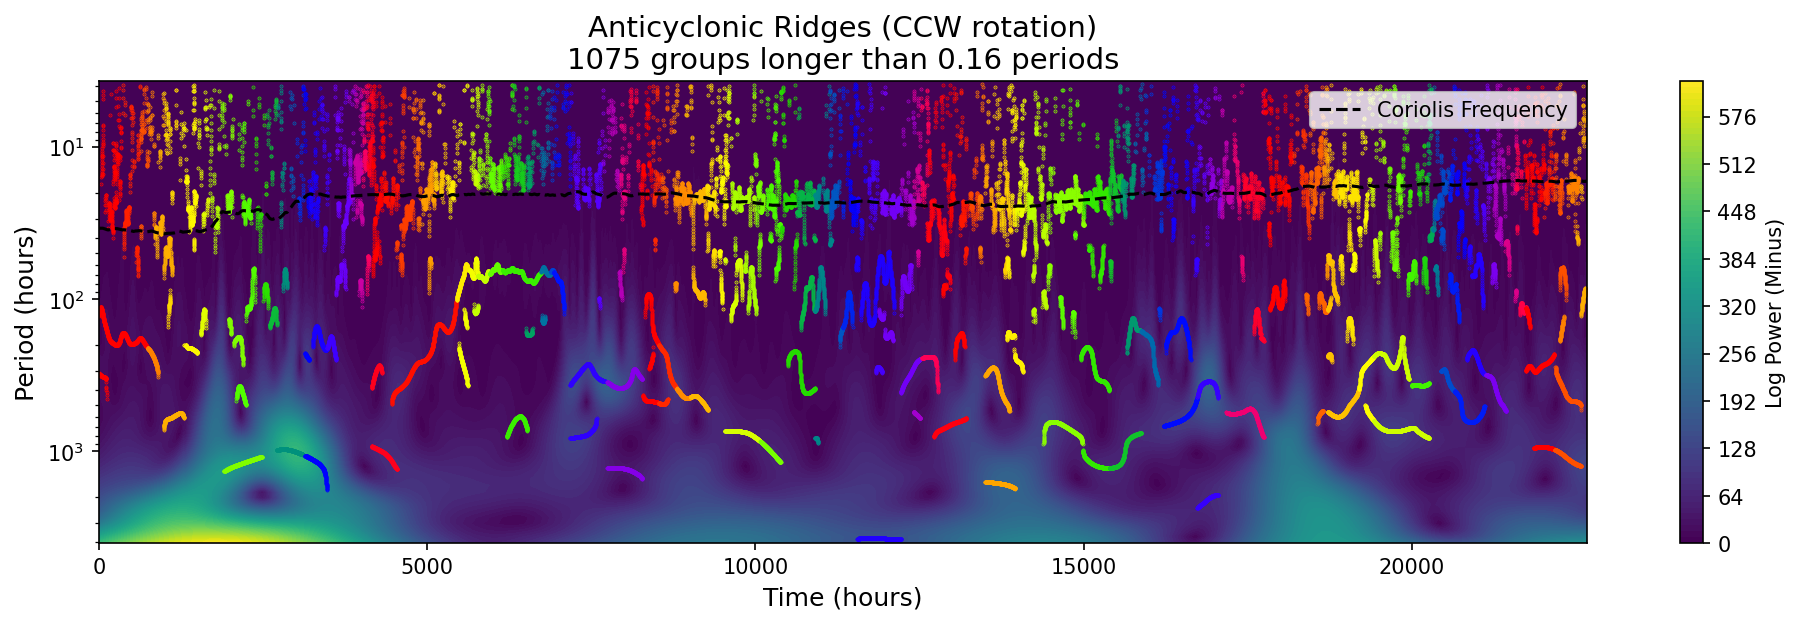

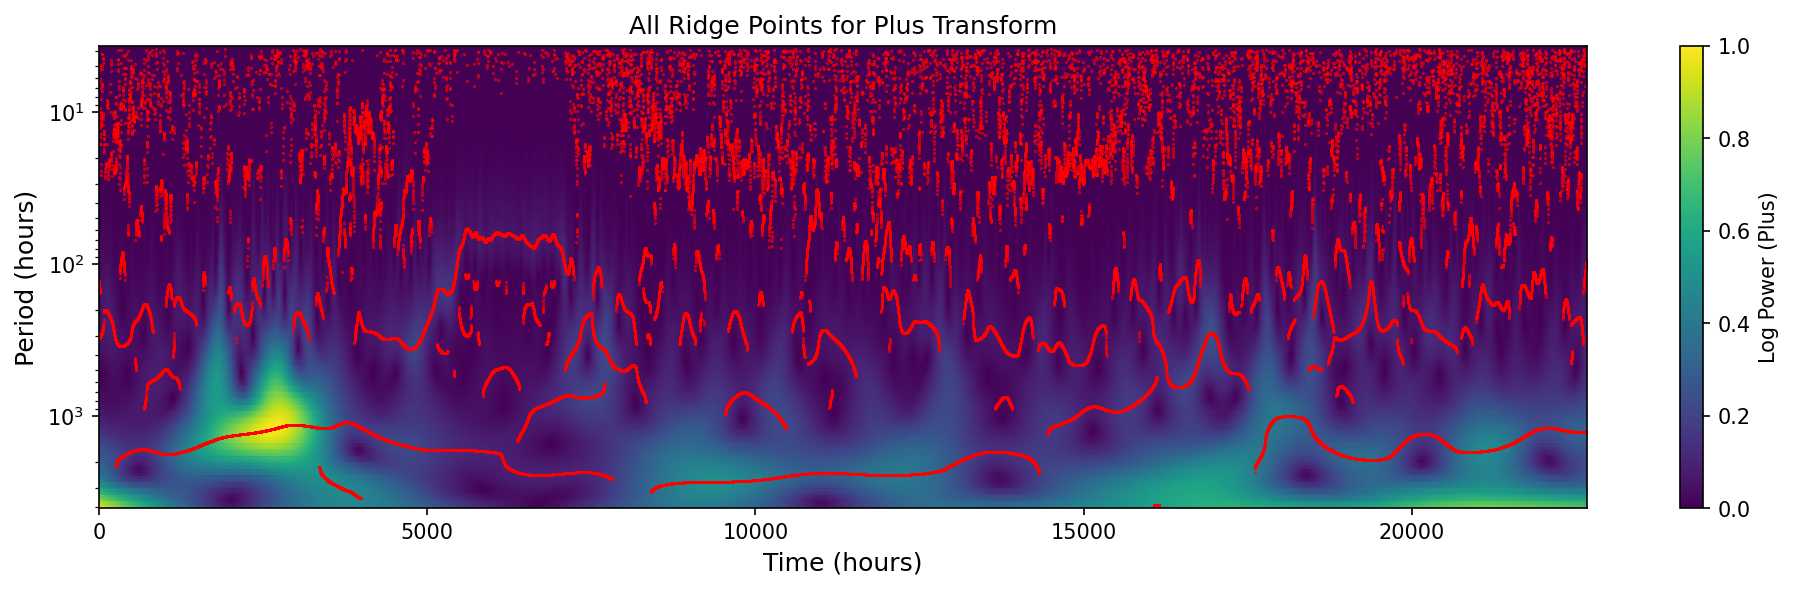

In [27]:
def wavelet_contourf(ax, time, frequencies, wavelet_coefficients, power=1, **contourf_args):
    time = np.asarray(time)
    frequencies = np.asarray(frequencies)
    wavelet_coefficients = np.asarray(wavelet_coefficients)
    if time.ndim != 1:
        raise ValueError('Expected 1d array for time')
    if frequencies.ndim != 1:
        raise ValueError('Expected 1d array for frequencies')
    if wavelet_coefficients.ndim != 2:
        raise ValueError('Expected 2d array for wavelet_coefficients')
    if wavelet_coefficients.shape != (len(frequencies), len(time)):
        raise ValueError('Expected wavelet_coefficients to have shape ({}, {}). Actual shape: {}'.format(
            len(frequencies), len(time), wavelet_coefficients.shape))
    if not np.isrealobj(wavelet_coefficients) or power != 1:
        wavelet_coefficients = np.abs(wavelet_coefficients)
    if power != 1:
        wavelet_coefficients = np.power(wavelet_coefficients, power)
    time, frequencies = np.meshgrid(time, frequencies)
    return ax.contourf(time, frequencies, wavelet_coefficients, **contourf_args)

# Helper function to get group data from the new dictionary structure
def get_group_data_from_dict(group_data_dict, group_id, data_index=1):
    """
    Extract data for a specific group from the dictionary format.
    
    Parameters:
    -----------
    group_data_dict : dict
        Dictionary of group data where keys are group IDs
    group_id : int
        Group ID to retrieve
    data_index : int, optional
        Index of the data to retrieve (0=ridge_quantity, 1=frequency, 2=inst_frequency)
    
    Returns:
    --------
    tuple: (freq_indices, time_indices, values)
    """
    if group_id not in group_data_dict:
        return [], [], np.array([])
        
    group_data = group_data_dict[group_id]
    freq_indices, time_indices = group_data['indices']
    values = group_data['values'][data_index]
    return freq_indices, time_indices, values

# Create a new figure with both wavelet transforms
plt.figure(figsize=(16, 4), dpi=150)
colors_plus = cm.prism(np.linspace(0, 1, num_groups_plus*2))

# Plot "plus" wavelet power as background
cax_plus = wavelet_contourf(
    plt.gca(), t, periods, power_plus, levels=100
)

# Loop through each filtered "plus" group
for group_id in filtered_group_ids_plus:
    # Get the ridge data from the dictionary format
    freq_indices, time_indices, freq_values = get_group_data_from_dict(
        group_data_plus, group_id, data_index=1  # 1 is the index for frequency values
    )
    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
    
    # Get color
    color_idx = (group_id - 1) % len(colors_plus)
    color = colors_plus[color_idx]
        
    # Calculate interpolated period values
    interp_period_values = 2.0 * np.pi / freq_values

    # Plot interpolated ridge points
    plt.scatter(t[time_indices], interp_period_values, 
                color=color, s=0.5, marker='.', linewidth=1.5)

# Plot Coriolis frequency
plt.plot(t, coriolis_period, color='black', linestyle='--', linewidth=1.5, label='Coriolis Frequency')

# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.colorbar(cax_plus, label='Log Power (Plus)')
plt.title(f'Cyclonic Ridges (CW rotation)\n{len(filtered_group_ids_plus)} groups longer than {min_length:.2f} periods', fontsize=14)
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Period (hours)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)

# # Set axis limits for zoomed region
# plt.xlim(6500, 6600)  # Time range from 5000 to 10000
# plt.ylim(80, 60)      # Period range from 50 to 300 (reversed due to invert_yaxis)

plt.show()
plt.close()

# Create a new figure for minus transform
plt.figure(figsize=(16, 4), dpi=150)
colors_minus = cm.prism(np.linspace(0, 1, num_groups_minus*2))

# Plot "minus" wavelet power as background
cax_minus = wavelet_contourf(
    plt.gca(), t, periods, power_minus, levels=100
)

# Loop through each filtered "minus" group
for group_id in filtered_group_ids_minus:
    # Get the ridge data from the dictionary format
    freq_indices, time_indices, freq_values = get_group_data_from_dict(
        group_data_minus, group_id, data_index=1  # 1 is the index for frequency values
    )
    
    # Skip if empty
    if len(freq_indices) == 0:
        continue
    
    # Get color
    color_idx = (group_id - 1) % len(colors_minus)
    color = colors_minus[color_idx]
        
    # Calculate interpolated period values
    interp_period_values = 2.0 * np.pi / freq_values

    # Plot interpolated ridge points
    plt.scatter(t[time_indices], interp_period_values, 
                color=color, s=0.5, marker='.', linewidth=1.5)

# Plot Coriolis frequency
plt.plot(t, coriolis_period, color='black', linestyle='--', linewidth=1.5, label='Coriolis Frequency')

# Set plot properties
plt.yscale('log')
plt.gca().invert_yaxis()
plt.colorbar(cax_minus, label='Log Power (Minus)')
plt.title(f'Anticyclonic Ridges (CCW rotation)\n{len(filtered_group_ids_minus)} groups longer than {min_length:.2f} periods', fontsize=14)
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Period (hours)', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.show()
plt.close()

# Plot all ridge points for wavelet_plus
plt.figure(figsize=(16, 4), dpi=150)
plt.pcolormesh(t, periods, power_plus, shading='gouraud', cmap='viridis')
freq_indices, time_indices = ridge_data_plus['indices']
freq_values = ridge_data_plus['values'][1]
period_values = 2.0 * np.pi / freq_values
plt.scatter(t[time_indices], period_values, color='red', s=0.5, marker='.')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.colorbar(label='Log Power (Plus)')
plt.title('All Ridge Points for Plus Transform')
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Period (hours)', fontsize=12)
plt.show()
plt.close()


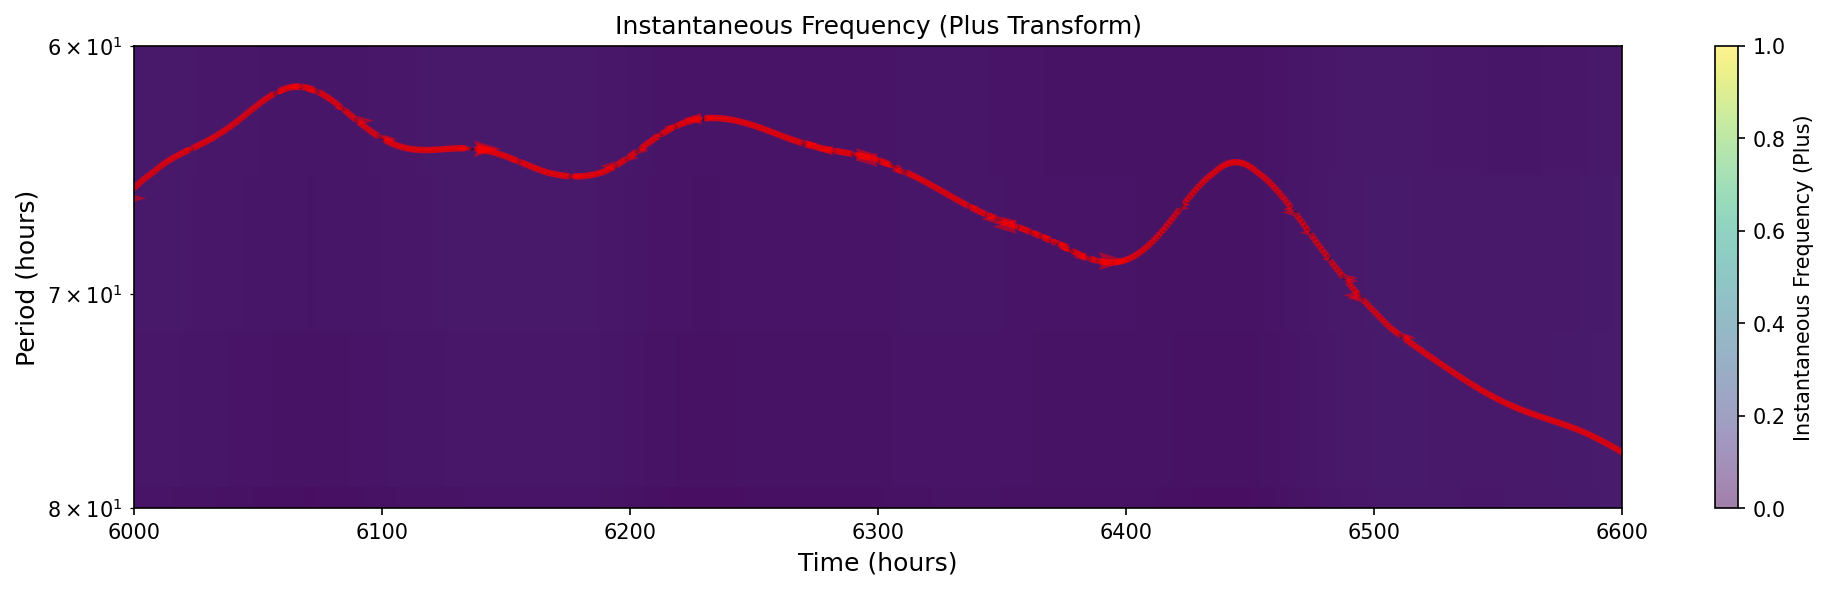

In [13]:
# Plot the instantaneous frequency (not a contour plot)
plt.figure(figsize=(16, 4), dpi=150)
plt.pcolormesh(
    t, periods, power_plus, cmap='viridis'
)

# Overlap ridge points as small black dots
freq_indices, time_indices = ridge_data_plus['indices']
frequency_values = ridge_data_plus['values'][1]
plt.scatter(t[time_indices], 2.0*np.pi / frequency_values, 
            color='black', s=0.1, marker='.')

# Plot the derivative of the instantaneous frequency as a vector field
inst_frequency_derivative_plus = ridge_data_plus['values'][3]
plt.quiver(t[time_indices], 2.0*np.pi / frequency_values, 
           inst_frequency_derivative_plus[time_indices], 
           np.zeros_like(inst_frequency_derivative_plus[time_indices]), 
           color='red', scale=10, width=0.005, alpha=0.5)

plt.colorbar(label='Instantaneous Frequency (Plus)')
plt.title('Instantaneous Frequency (Plus Transform)')
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('Period (hours)', fontsize=12)
plt.yscale('log')
plt.gca().invert_yaxis()

# Set axis limits for zoomed region
plt.xlim(6000, 6600)  # Time range from 5000 to 10000
plt.ylim(80, 60)      # Period range from 50 to 300 (reversed due to invert_yaxis)

plt.show()
plt.close()

In [ ]:
def analyze_drifter(drifter_id, ds, traj_idx, min_length_factor=0.0, save_plots=True):
    """
    Analyze a single drifter with wavelet ridge detection and plot the results.
    
    Parameters
    ----------
    drifter_id : int
        Drifter ID to analyze
    ds : xarray.Dataset
        Dataset containing drifter data
    traj_idx : list
        Trajectory index for the ragged array
    min_length_factor : float, optional
        Factor to multiply with the minimum ridge length, defaults to 0.1
    save_plots : bool, optional
        Whether to save plots to files, defaults to True
    
    Returns
    -------
    dict
        Dictionary containing ridge detection results
    """
    try:
        # Find drifter index
        j = int(np.where(ds["id"] == drifter_id)[0][0])
        print(f'Processing drifter ID: {drifter_id} (index {j})')
        
        # Get slice for this drifter
        sli = slice(traj_idx[j], traj_idx[j+1])
        
        # Extract coordinates
        lat = ds.lat[sli].values
        lon = ds.lon[sli].values
        
        # Calculate the Coriolis frequency
        coriolis_freq = coriolis_frequency(lat)

        # Convert Coriolis frequency to radians per hour
        coriolis_freq_rad = coriolis_freq * 3600

        # Convert to displacements starting from the first point, accounting for curvature
        x_t = (lon-lon[0])*np.cos(np.radians(lat[0]))*6378.0
        y_t = (lat-lat[0])*6378.0
        
        # Get time in hours
        t = ds.time[sli].values
        t = t.astype(float)
        t = t / 1e9 / 3600.0
        t = t - t[0]
        
        # Define Morse wavelet parameters
        gamma = 3
        beta = 2
        
        # Convert Coriolis frequency to period
        coriolis_period = 2.0*np.pi*(beta/gamma)**(1/gamma) / coriolis_freq_rad

        # Generate logarithmically spaced frequencies
        freqs = morse_logspace_freq(gamma, beta, len(t), density=4)
        
        # Apply the Morse wavelet transform
        wavelet_x = morse_wavelet_transform(x_t, gamma, beta, freqs, boundary="mirror")
        wavelet_y = morse_wavelet_transform(y_t, gamma, beta, freqs, boundary="mirror")
        
        # Calculate the power of the wavelet transform
        power = np.abs(wavelet_x)**2 + np.abs(wavelet_y)**2
        
        # Convert from frequencies to periods for plotting
        periods = 2.0*np.pi*(beta/gamma)**(1/gamma) / freqs
        
        # Find ridge points
        ridge_points, ridge_quantity, processed_transform, inst_frequency = isridgepoint(
            wavelet_transform=power,
            scale_frequencies=freqs,
            amplitude_threshold=0.1,
            ridge_type='amplitude'
        )
        
        # Separate ridge points into groups
        labeled_ridges, num_groups = separate_ridge_groups_dbscan(
            ridge_points, 
            eps=7.0,
            min_samples=5,
            scale_factor=3.0
        )
        
        # Skip if no groups found
        if num_groups == 0:
            print(f"No ridge groups found for drifter {drifter_id}")
            return None
        
        # Create empty lists to store group data
        group_lengths = []
        group_interpolated_power = []
        group_interpolated_freq = []
        
        # Process each group
        for group_id in range(1, num_groups + 1):
            # Extract ridge mask for the group
            group_mask = (labeled_ridges == group_id)
            
            # Create frequency meshgrid
            freq_mesh = np.zeros_like(power)
            for i, f in enumerate(freqs):
                freq_mesh[i, :] = f
            
            # Apply ridge interpolation
            interpolated_arrays = ridge_shift_interpolation(
                ridge_points=group_mask,
                ridge_quantity=power,
                y_arrays=[power, freq_mesh]
            )
            
            # Extract interpolated values
            interpolated_power = interpolated_arrays[0]
            interpolated_freq = interpolated_arrays[1]
            
            # Store interpolated values
            group_interpolated_power.append(interpolated_power)
            group_interpolated_freq.append(interpolated_freq)
            
            # Get indices of the group's ridge points
            group_freq_idx, group_time_idx = np.where(group_mask)
            
            # Skip empty groups
            if len(group_freq_idx) == 0:
                group_lengths.append(0)
                continue
            
            # Ensure time values are float type
            time_values = t[group_time_idx].astype(float)
            
            # Calculate the length of the group using trapezoid integration
            try:
                group_length = np.abs(np.trapezoid(
                    interpolated_freq[group_freq_idx, group_time_idx], 
                    x=time_values
                ))
                group_lengths.append(float(group_length))
            except Exception as e:
                print(f"Error calculating length for group {group_id}: {e}")
                group_lengths.append(0)
        
        # Convert to numpy array for consistent type comparison
        group_lengths = np.array(group_lengths, dtype=float)
        
        # Calculate minimum length threshold
        min_length = min_length_factor * (2.0 * np.sqrt(beta * gamma) / np.pi)
        
        # Filter out groups with length less than min_length
        filtered_group_ids = [i+1 for i, length in enumerate(group_lengths) if length >= min_length]
        print(f"Found {len(filtered_group_ids)} filtered groups out of {num_groups} total")
        
        # Skip if no filtered groups found
        if len(filtered_group_ids) == 0:
            print(f"No groups above minimum length for drifter {drifter_id}")
            return None
        
        # Create figure for this drifter
        plt.figure(figsize=(25, 5), dpi=300)
        
        # Plot wavelet power as background
        plt.pcolormesh(t, periods, np.log(power), shading='gouraud', cmap='viridis')
        
        # Set up colors for groups
        colors = cm.prism(np.linspace(0, 1, num_groups*2))
        
        # Plot filtered groups
        for group_id in filtered_group_ids:
            # Get color
            color_idx = (group_id - 1) % len(colors)
            color = colors[color_idx]
            
            # Get mask for this group
            group_mask = (labeled_ridges == group_id)
            
            # Get indices of the group's ridge points
            group_freq_idx, group_time_idx = np.where(group_mask)
            
            # Skip empty groups
            if len(group_freq_idx) == 0:
                continue
            
            # Get interpolated frequency values
            interp_freq = group_interpolated_freq[group_id - 1]
            interp_freq_values = np.array([interp_freq[f, t] for f, t in zip(group_freq_idx, group_time_idx)])
            interp_period_values = 2.0*np.pi*(beta/gamma)**(1/gamma) / interp_freq_values
            
            # Plot interpolated ridge points
            plt.scatter(t[group_time_idx], interp_period_values, 
                        color=color, s=15, marker='.', linewidth=1.5, 
                        label=f"Group {group_id}" if group_id <= 10 else "")
        
        # Plot Coriolis frequency
        plt.plot(t, coriolis_period, color='black', linestyle='--', linewidth=1.5, label='Coriolis Frequency')

        # Set plot properties
        plt.yscale('log')
        plt.gca().invert_yaxis()
        plt.colorbar(label='Log(Power)')
        plt.title(f'Drifter {drifter_id}: Ridge Groups (min length: {min_length:.2f} periods)', fontsize=14)
        plt.xlabel('Time (hours)', fontsize=12)
        plt.ylabel('Period (hours)', fontsize=12)
        plt.legend(loc='upper right', fontsize=10)
        plt.tight_layout()       
        plt.show()
        plt.close()
        
        return {
            'drifter_id': drifter_id,
            'num_groups': num_groups,
            'filtered_groups': len(filtered_group_ids),
            'group_lengths': group_lengths,
            'min_length': min_length
        }
        
    except Exception as e:
        print(f"Error processing drifter {drifter_id}: {e}")
        return None

# Main processing code
def process_drifters(drifter_ids, save_plots=True):
    """Process multiple drifters and collect results."""
    # Load drifter data
    ds = gdp1h()
    traj_idx = cd.ragged.rowsize_to_index(ds["rowsize"])
    
    # Store results for all drifters
    results = []
    
    # Process each drifter
    for drifter_id in tqdm(drifter_ids):
        result = analyze_drifter(drifter_id, ds, traj_idx, save_plots=save_plots)
        if result:
            results.append(result)
    
    return results

# Process the first 20 drifters
example_ids = ds["id"][0:20].values

# Add a specific drifter ID for testing
example_ids = np.insert(example_ids, 0, 44000)

# Process all drifters
results = process_drifters(example_ids)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from clouddrift.ridges import isridgepoint

# Create a finer 2D grid for better visualization
nt, nf = 200, 100  # time points, frequency bins
t = np.linspace(0, 10, nt)  # time axis
f = np.linspace(0.1, 2.0, nf)  # frequency axis

# Create a sinusoidal ridge path in time-frequency space
center_freq = 1.0 + 0.3 * np.sin(t * 0.8)  # center frequency of ridge varies with time

# Create a 2D wavelet transform with a Gaussian ridge
sigma_f = 0.1  # width of the ridge in frequency direction
wavelet = np.zeros((nt, nf), dtype=complex)

# Create frequency grid for each time point
f_grid = np.tile(f, (nt, 1))
t_grid = np.tile(t[:, np.newaxis], (1, nf))
center_freq_grid = np.tile(center_freq[:, np.newaxis], (1, nf))

# Generate Gaussian ridge along time-varying center frequency
wavelet = np.exp(-((f_grid - center_freq_grid)**2) / (2 * sigma_f**2))

# Add some random phase variation along the ridge
phase = np.cumsum(0.2 * np.random.randn(nt)) 
phase_grid = np.tile(phase[:, np.newaxis], (1, nf))
wavelet = wavelet * np.exp(1j * phase_grid)

# Add some noise
noise_level = 0.005
wavelet += noise_level * (np.random.randn(*wavelet.shape) + 1j * np.random.randn(*wavelet.shape))

# Apply ridge detection
ridge_points, ridge_quantity, processed_transform, inst_frequency = isridgepoint(
    wavelet,
    f * 2 * np.pi,  # convert to radians for the algorithm
    amplitude_threshold=0.2,
    ridge_type='amplitude'
)

# Plot the results
plt.figure(figsize=(12, 10))

# Plot the amplitude of the wavelet transform
plt.subplot(211)
plt.pcolormesh(t, f, np.abs(wavelet).T, shading='auto', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.plot(t, center_freq, 'r--', linewidth=2, label='True Ridge Path')
plt.title('Synthetic Wavelet Transform with Gaussian Ridge')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()

# Plot the ridge points
plt.subplot(212)
plt.pcolormesh(t, f, ridge_points.T, shading='auto', cmap='Reds')
plt.colorbar(label='Ridge Points')
plt.plot(t, center_freq, 'b--', linewidth=2, label='True Ridge Path')
plt.title('Detected Ridge Points')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# 3D visualization of the ridge
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for 3D plot
T, F = np.meshgrid(t, f)

# Plot the 3D surface representing the wavelet amplitude
stride = 4  # Skip points for cleaner visualization
ax.plot_surface(T[::stride, ::stride], F[::stride, ::stride], 
                np.abs(wavelet).T[::stride, ::stride], 
                cmap='viridis', alpha=0.7)

# Highlight the actual ridge line in 3D space
ax.plot(t, center_freq, np.max(np.abs(wavelet))*1.1, 'r-', linewidth=3, label='True Ridge')

ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_zlabel('Amplitude')
ax.set_title('3D Visualization of Gaussian Ridge')
ax.legend()

plt.tight_layout()
plt.show()